# Import Library

In [2]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# File Directory

In [ ]:
# /kaggle/input/rsna-pneumonia-detection-challenge/stage_2_test_images
# /kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images
# /kaggle/input/rsna-pneumonia-detection-challenge/GCP Credits Request Link - RSNA.txt
# /kaggle/input/rsna-pneumonia-detection-challenge/stage_2_sample_submission.csv
# /kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv

# Preprocessing The Images

In [3]:
labels = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')

In [4]:
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [5]:
labels = labels.drop_duplicates('patientId')

In [6]:
labels.patientId.iloc[0]

'0004cfab-14fd-4e49-80ba-63a80b6bddd6'

In [7]:
ROOT_PATH = Path('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images')
SAVE_PATH = Path('/kaggle/working/Processed')

# Sample Image Visualization

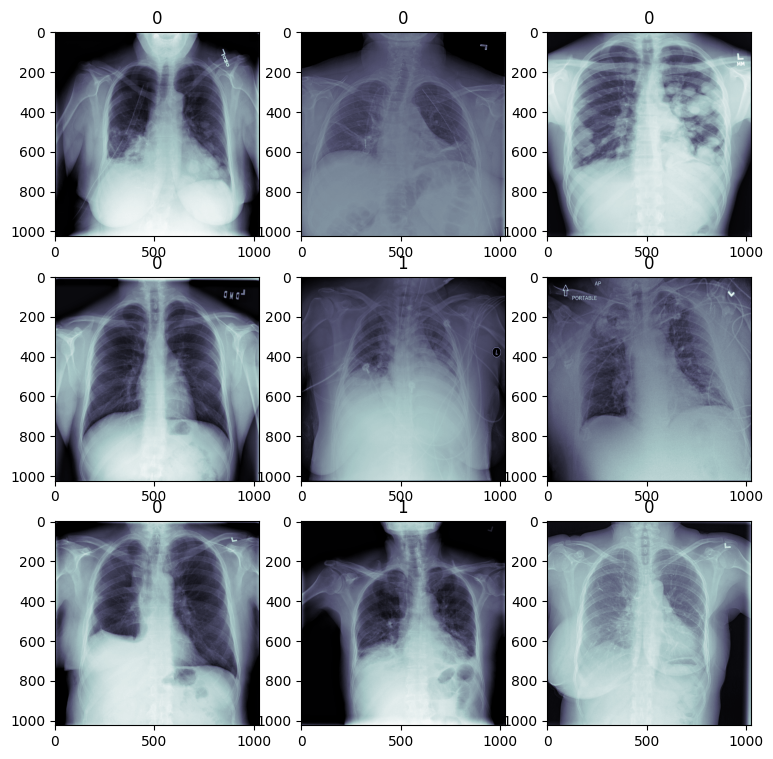

In [8]:
fig, axis = plt.subplots(3,3,figsize=(9,9))
c=0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix('.dcm')
        dcm = pydicom.dcmread(dcm_path).pixel_array
        
        label = labels['Target'].iloc[c]
        axis[i][j].imshow(dcm,cmap='bone')
        axis[i][j].set_title(label)
        c += 1

# Normalization

In [9]:
sums, sums_squared = 0.0, 0.0  # use float

for c, patient_id in enumerate(tqdm(labels.patientId)):
    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH / patient_id
    dcm_path = dcm_path.with_suffix('.dcm')
    
    # Read dicom & normalize to [0,1]
    dcm = pydicom.dcmread(dcm_path).pixel_array / 255.0
    
    # EfficientNetB4 input size (380x380)
    dcm_array = cv2.resize(dcm, (380,380)).astype(np.float32)  # <- float32 for calculations
    
    label = labels.Target.iloc[c]
    train_or_val = 'train' if c < 24000 else 'val'
    
    current_save_path = SAVE_PATH / train_or_val / str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path / patient_id, dcm_array.astype(np.float16))  # optional storage in float16
    
    # Update normalizer for 380x380
    normalizer = 380 * 380
    if train_or_val == 'train':
        sums += np.sum(dcm_array) / normalizer
        sums_squared += np.sum(dcm_array ** 2) / normalizer


  0%|          | 0/26684 [00:00<?, ?it/s]

In [10]:
mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean**2)

In [11]:
mean, std

(0.4901771443456668, 0.2479165219853481)

# Train

In [7]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    
    #  Use dataset mean/std (replace with your computed values)
    transforms.Normalize(mean=[mean], std=[std]),
    
    #  Augmentations
    transforms.RandomAffine(degrees=(-5,5), translate=(0,0.05), scale=(0.9,1.1)),
    transforms.RandomResizedCrop((380,380), scale=(0.35,1))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std]),
    transforms.Resize((380,380))   # ensure val images match EfficientNetB4 input
])

In [16]:
train_dataset

Dataset DatasetFolder
    Number of datapoints: 24000
    Root location: /kaggle/working/Processed/train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.4901771443456668], std=[0.2479165219853481])
               RandomAffine(degrees=[-5.0, 5.0], translate=(0, 0.05), scale=(0.9, 1.1))
               RandomResizedCrop(size=(380, 380), scale=(0.35, 1), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
           )

In [17]:
x_ray, label = train_dataset[0]

In [18]:
x_ray

tensor([[[-1.9456, -1.9456, -1.9456,  ..., -1.9772, -1.9770, -1.9765],
         [-1.9456, -1.9456, -1.9456,  ..., -1.9772, -1.9772, -1.9772],
         [-1.9312, -1.9426, -1.9358,  ..., -1.9772, -1.9772, -1.9772],
         ...,
         [-1.8056, -1.7317, -1.6987,  ...,  0.0000,  0.0000,  0.0000],
         [-1.8348, -1.7392, -1.6770,  ...,  0.0000,  0.0000,  0.0000],
         [-1.8348, -1.7608, -1.7417,  ...,  0.0000,  0.0000,  0.0000]]])

In [19]:
type(x_ray)

torch.Tensor

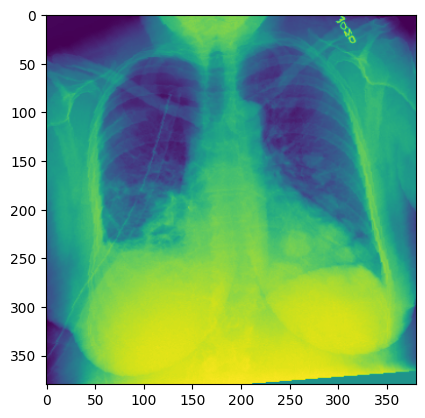

In [20]:
plt.imshow(x_ray[0])

In [21]:
label

0

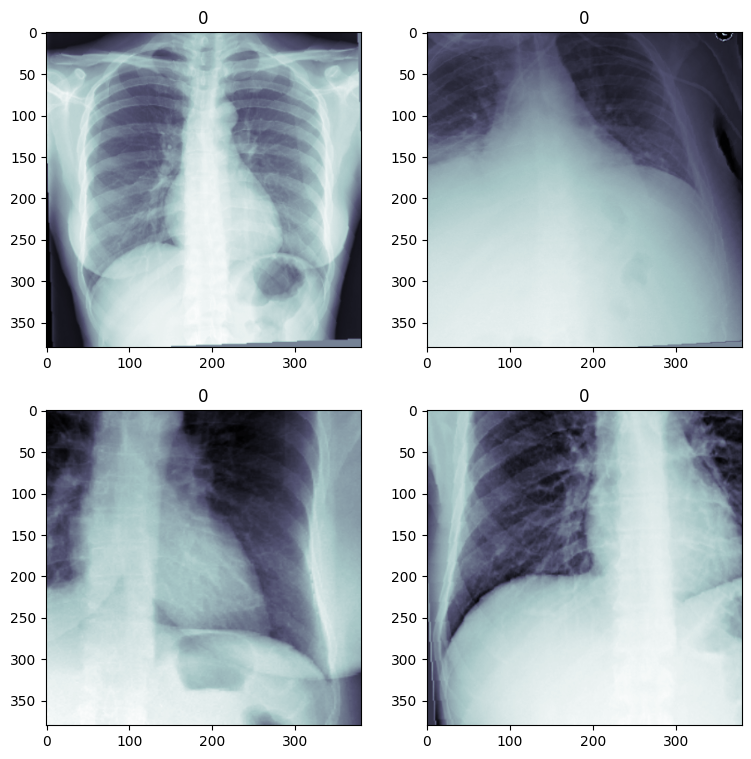

In [22]:
fig, axis = plt.subplots(2,2,figsize=(9,9))

for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0,24000)
        x_ray, labek = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0],cmap='bone')
        axis[i][j].set_title(label)

In [23]:
batch_size = 16   # reduce batch size (EfficientNetB4 uses more memory)
num_workers = 0   # can increase if you have strong CPU

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=True
)


In [24]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

There we see Class: 0 contains 18,593 images and Class: 1 contains 5,407 images which is far small. So the dataset is imbalanced. We can handle the situation in three ways:

* Do nothing
* Awaited Loss Fucntion
* Over Sampling

# Model

In [25]:
from torchvision.models import efficientnet_b0, efficientnet_b1, efficientnet_b2, efficientnet_b3, efficientnet_b4

model = efficientnet_b4(weights="IMAGENET1K_V1")  # pretrained weights

In [ ]:
# class PneumoniaModel(pl.LightningModule):

#     def __init__(self):
#         super().__init__()
        
#         self.model = torchvision.models.resnet18()
#         self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#         self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
#         self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))

#         self.train_acc = torchmetrics.Accuracy()
#         self.val_acc = torchmetrics.Accuracy()

#     def forward(self, data):
#         pred = self.model(data)
#         return pred

#     def training_step(self, batch, batch_idx):
#         x_ray, label = batch
#         label = label.float()
#         pred = self(x_ray)[:,0]
#         loss = self.loss_fn(pred,label)

#         self.log("Train Loss", loss)
#         self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))

#         return loss

#     def training_epoch_end(self,outs):
#         self.log("Train ACC", self.train_acc.compute())
#         self.train_acc.reset()

#     def validation_step(self, batch, batch_idx):
#         x_ray, label = batch
#         label = label.float()
#         pred = self(x_ray)[:,0]
#         loss = self.loss_fn(pred,label)

#         self.log("Val Loss", loss)
#         self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))


#     def validation_epoch_end(self,outs):
#         self.log("Val ACC", self.val_acc.compute())
#         self.val_acc.reset()

#     def configure_optimizers(self):
#         return [self.optimizer]

In [16]:
import pytorch_lightning as pl
import torch
from torch import nn
import torchmetrics
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # Load EfficientNet-B4 with pretrained weights
        weights = EfficientNet_B4_Weights.DEFAULT
        self.model = efficientnet_b4(weights=weights)

        # Modify first conv layer to accept single-channel (grayscale) images
        self.model.features[0][0] = nn.Conv2d(
            1, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
        )

        # Replace classifier for binary output
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)

        # Loss function
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0]))

        # Metrics
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)[:, 0]
        loss = self.loss_fn(logits, y)

        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())

        # Lightning logging
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_step_acc", acc, prog_bar=True)

        return loss

    def on_train_epoch_end(self):
        self.log("train_epoch_acc", self.train_acc.compute(), prog_bar=True)
        self.train_acc.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)[:, 0]
        loss = self.loss_fn(logits, y)

        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_step_acc", acc, prog_bar=True)

    def on_validation_epoch_end(self):
        self.log("val_epoch_acc", self.val_acc.compute(), prog_bar=True)
        self.val_acc.reset()

    def configure_optimizers(self):
        # AdamW optimizer with weight decay
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-4)

        # Cosine Annealing LR scheduler
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=10, eta_min=1e-6
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }


In [17]:
model = PneumoniaModel()

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 153MB/s] 


In [30]:
model

PneumoniaModel(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [31]:
[0] * 5

[0, 0, 0, 0, 0]

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_epoch_acc",   
    save_top_k=10,
    mode="max"
)


In [36]:
gpus = 1
trainer = pl.Trainer( logger=TensorBoardLogger(save_dir='./logs'),
                    log_every_n_steps=1,callbacks=checkpoint_callback,max_epochs=10)

In [37]:
trainer.fit(model,train_loader,val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [75]:
model = PneumoniaModel.load_from_checkpoint(
    "/kaggle/working/logs/lightning_logs/version_4/checkpoints/epoch=9-step=15000.ckpt",
)



In [ ]:
# /kaggle/working/Processed/val/0/0053ee32-1e03-4dc2-a103-f46ad0448787.npy

In [77]:
preds[:10]

tensor([0.1622, 0.0041, 0.0088, 0.0267, 0.0136, 0.0410, 0.4351, 0.0237, 0.0091,
        0.1804])

In [78]:
labels[:10]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)

In [79]:
acc= torchmetrics.Accuracy(task="binary")(preds,labels)
precision = torchmetrics.Precision(task="binary")(preds,labels)
recall = torchmetrics.Recall(task="binary")(preds,labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2,task="binary")(preds,labels)

In [80]:
acc

tensor(0.8439)

In [81]:
precision

tensor(0.6673)

In [82]:
recall

tensor(0.6132)

In [83]:
cm

tensor([[1894,  185],
        [ 234,  371]])

🔍 Looking for training logs...
📊 Plotting metrics for version_4 (EfficientNet-B4)...
Available metrics: ['train_loss', 'train_step_acc', 'epoch', 'val_loss', 'val_step_acc', 'val_epoch_acc', 'train_epoch_acc']


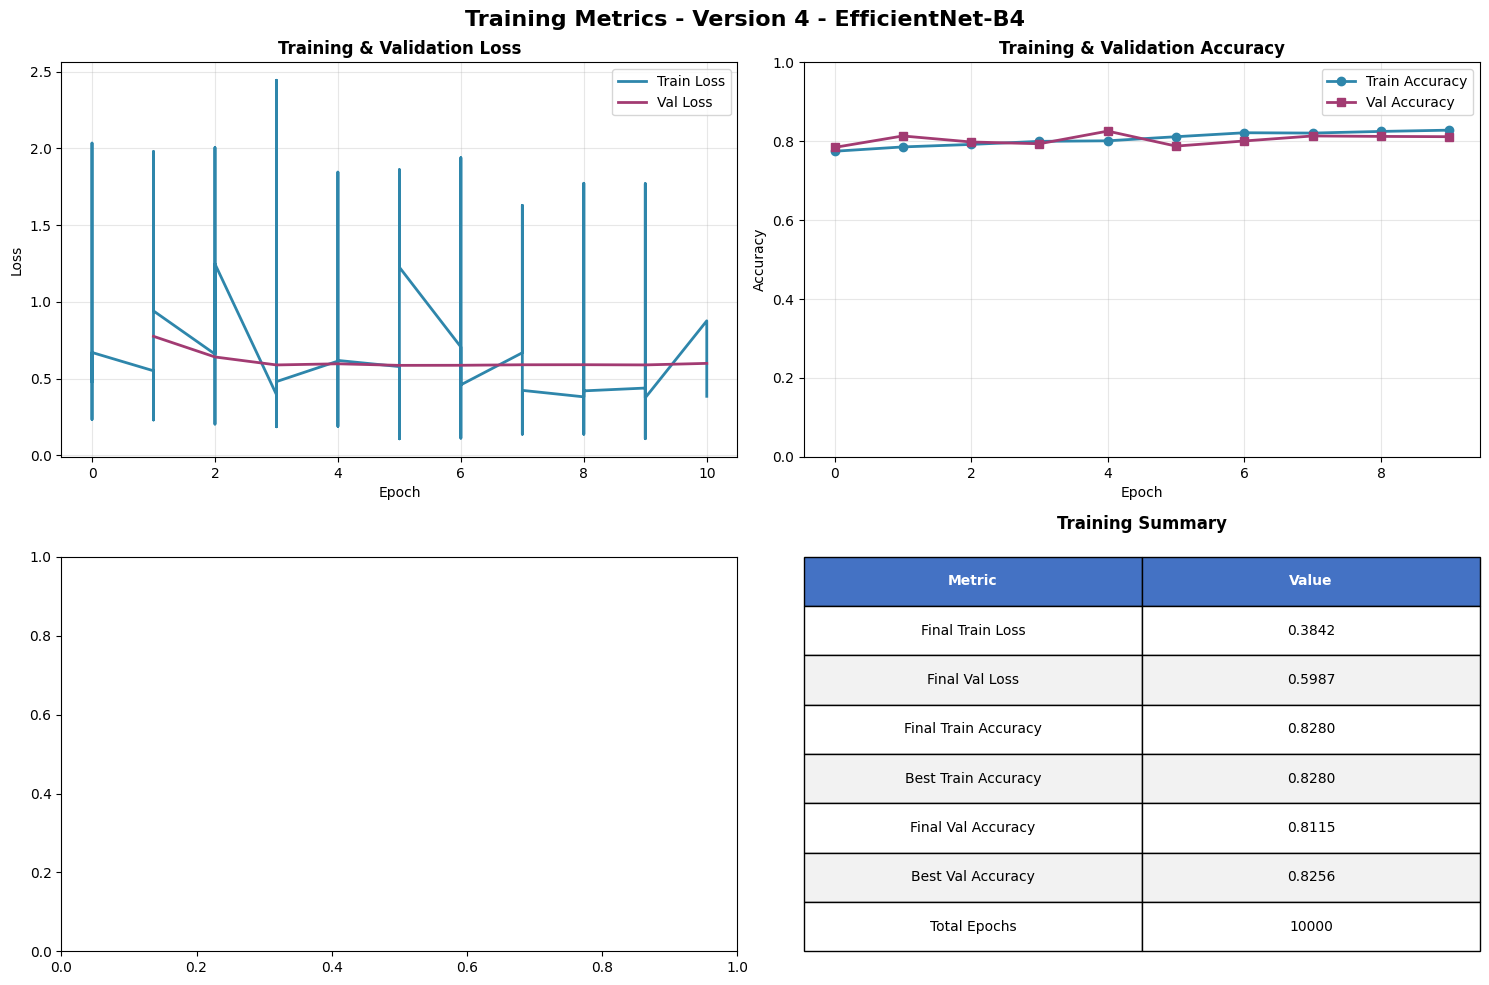


✅ Metrics extracted successfully!
Available metrics: ['train_loss', 'train_step_acc', 'epoch', 'val_loss', 'val_step_acc', 'val_epoch_acc', 'train_epoch_acc']

📋 Alternative: Manual metrics input
If the above failed, please provide your training metrics manually.
You can find them in your Kaggle notebook output or training logs.


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np

def extract_tensorboard_data(log_dir):
    """Extract metrics from TensorBoard event files"""
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()
    
    # Get available scalar tags
    tags = event_acc.Tags()['scalars']
    print(f"Available metrics: {tags}")
    
    metrics_data = {}
    
    # Extract each metric
    for tag in tags:
        scalar_events = event_acc.Scalars(tag)
        steps = [event.step for event in scalar_events]
        values = [event.value for event in scalar_events]
        epochs = [event.wall_time for event in scalar_events]  # We'll convert this to epochs
        
        metrics_data[tag] = {
            'steps': steps,
            'values': values,
            'wall_time': epochs
        }
    
    return metrics_data

def plot_training_metrics(version_path, version_name=""):
    """Create comprehensive training metrics plots"""
    
    # Extract data
    try:
        metrics_data = extract_tensorboard_data(version_path)
    except Exception as e:
        print(f"Error reading TensorBoard data: {e}")
        return None
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Training Metrics - {version_name}', fontsize=16, fontweight='bold')
    
    # Define colors
    colors = {
        'train': '#2E86AB',
        'val': '#A23B72',
        'epoch': '#F18F01',
        'step': '#C73E1D'
    }
    
    # Plot 1: Loss over epochs
    ax1 = axes[0, 0]
    train_loss_keys = [k for k in metrics_data.keys() if 'train_loss' in k]
    val_loss_keys = [k for k in metrics_data.keys() if 'val_loss' in k]
    
    if train_loss_keys:
        steps = metrics_data[train_loss_keys[0]]['steps']
        values = metrics_data[train_loss_keys[0]]['values']
        epochs = [s // (max(steps) // 10) for s in steps]  # Approximate epochs
        ax1.plot(epochs, values, label='Train Loss', color=colors['train'], linewidth=2)
    
    if val_loss_keys:
        steps = metrics_data[val_loss_keys[0]]['steps']
        values = metrics_data[val_loss_keys[0]]['values']
        epochs = [s // (max(steps) // 10) for s in steps]
        ax1.plot(epochs, values, label='Val Loss', color=colors['val'], linewidth=2)
    
    ax1.set_title('Training & Validation Loss', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy over epochs
    ax2 = axes[0, 1]
    train_acc_keys = [k for k in metrics_data.keys() if 'train' in k and 'acc' in k]
    val_acc_keys = [k for k in metrics_data.keys() if 'val' in k and 'acc' in k]
    
    if train_acc_keys:
        # Use epoch accuracy if available, otherwise step accuracy
        epoch_acc_key = next((k for k in train_acc_keys if 'epoch' in k), train_acc_keys[0])
        steps = metrics_data[epoch_acc_key]['steps']
        values = metrics_data[epoch_acc_key]['values']
        epochs = list(range(len(values)))
        ax2.plot(epochs, values, label='Train Accuracy', color=colors['train'], linewidth=2, marker='o')
    
    if val_acc_keys:
        epoch_acc_key = next((k for k in val_acc_keys if 'epoch' in k), val_acc_keys[0])
        steps = metrics_data[epoch_acc_key]['steps']
        values = metrics_data[epoch_acc_key]['values']
        epochs = list(range(len(values)))
        ax2.plot(epochs, values, label='Val Accuracy', color=colors['val'], linewidth=2, marker='s')
    
    ax2.set_title('Training & Validation Accuracy', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])
    
    # Plot 3: Learning Rate (if available)
    # ax3 = axes[1, 0]
    # lr_keys = [k for k in metrics_data.keys() if 'lr' in k.lower() or 'learning_rate' in k.lower()]
    
    # if lr_keys:
    #     steps = metrics_data[lr_keys[0]]['steps']
    #     values = metrics_data[lr_keys[0]]['values']
    #     epochs = [s // (max(steps) // 10) for s in steps]
    #     ax3.plot(epochs, values, color=colors['epoch'], linewidth=2)
    #     ax3.set_title('Learning Rate Schedule', fontweight='bold')
    #     ax3.set_xlabel('Epoch')
    #     ax3.set_ylabel('Learning Rate')
    #     ax3.set_yscale('log')
    # else:
    #     ax3.text(0.5, 0.5, 'Learning Rate\ndata not available', 
    #             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    #     ax3.set_title('Learning Rate Schedule', fontweight='bold')
    
    # ax3.grid(True, alpha=0.3)
    
    # Plot 4: Metrics Summary Table
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Create summary statistics
    summary_data = []
    
    # Get final values
    if train_loss_keys:
        final_train_loss = metrics_data[train_loss_keys[0]]['values'][-1]
        summary_data.append(['Final Train Loss', f'{final_train_loss:.4f}'])
    
    if val_loss_keys:
        final_val_loss = metrics_data[val_loss_keys[0]]['values'][-1]
        summary_data.append(['Final Val Loss', f'{final_val_loss:.4f}'])
    
    if train_acc_keys:
        epoch_acc_key = next((k for k in train_acc_keys if 'epoch' in k), train_acc_keys[0])
        final_train_acc = metrics_data[epoch_acc_key]['values'][-1]
        summary_data.append(['Final Train Accuracy', f'{final_train_acc:.4f}'])
        
        # Best accuracy
        best_train_acc = max(metrics_data[epoch_acc_key]['values'])
        summary_data.append(['Best Train Accuracy', f'{best_train_acc:.4f}'])
    
    if val_acc_keys:
        epoch_acc_key = next((k for k in val_acc_keys if 'epoch' in k), val_acc_keys[0])
        final_val_acc = metrics_data[epoch_acc_key]['values'][-1]
        summary_data.append(['Final Val Accuracy', f'{final_val_acc:.4f}'])
        
        # Best accuracy
        best_val_acc = max(metrics_data[epoch_acc_key]['values'])
        summary_data.append(['Best Val Accuracy', f'{best_val_acc:.4f}'])
    
    # Total epochs
    total_epochs = len(metrics_data[list(metrics_data.keys())[0]]['values'])
    summary_data.append(['Total Epochs', str(total_epochs)])
    
    # Create table
    if summary_data:
        table = ax4.table(cellText=summary_data,
                         colLabels=['Metric', 'Value'],
                         cellLoc='center',
                         loc='center',
                         bbox=[0, 0, 1, 1])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        
        # Style the table
        for i in range(len(summary_data) + 1):
            for j in range(2):
                cell = table[(i, j)]
                if i == 0:  # Header
                    cell.set_facecolor('#4472C4')
                    cell.set_text_props(weight='bold', color='white')
                else:
                    cell.set_facecolor('#F2F2F2' if i % 2 == 0 else 'white')
    
    ax4.set_title('Training Summary', fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    return metrics_data

# Main execution
print("🔍 Looking for training logs...")

# Check version_4 (your EfficientNet-B4 training)
version_4_path = "/kaggle/working/logs/lightning_logs/version_4"

if os.path.exists(version_4_path):
    print("📊 Plotting metrics for version_4 (EfficientNet-B4)...")
    metrics_data = plot_training_metrics(version_4_path, "Version 4 - EfficientNet-B4")
    
    if metrics_data:
        print("\n✅ Metrics extracted successfully!")
        print(f"Available metrics: {list(metrics_data.keys())}")
    else:
        print("❌ Failed to extract metrics. Let's try alternative approach...")

# Alternative: Manual CSV approach if TensorBoard fails
print("\n" + "="*50)
print("📋 Alternative: Manual metrics input")
print("If the above failed, please provide your training metrics manually.")
print("You can find them in your Kaggle notebook output or training logs.")

In [4]:
import os
from pathlib import Path
import mimetypes
from collections import Counter

# Define the path to inspect
INSPECT_PATH = Path('/kaggle/working/Processed/train/0')

def inspect_directory_files(directory_path):
    """
    Inspect all files in a directory and determine their types
    """
    if not directory_path.exists():
        print(f"Directory does not exist: {directory_path}")
        return
    
    if not directory_path.is_dir():
        print(f"Path is not a directory: {directory_path}")
        return
    
    print(f"Inspecting directory: {directory_path}")
    print("=" * 60)
    
    # Get all files in the directory
    files = [f for f in directory_path.iterdir() if f.is_file()]
    
    if not files:
        print("No files found in the directory.")
        return
    
    print(f"Found {len(files)} files")
    print("-" * 40)
    
    file_extensions = Counter()
    file_info = []
    
    for file_path in files:
        # Get file extension
        extension = file_path.suffix.lower()
        file_extensions[extension] += 1
        
        # Get file size
        file_size = file_path.stat().st_size
        
        # Try to guess MIME type
        mime_type, _ = mimetypes.guess_type(str(file_path))
        
        file_info.append({
            'name': file_path.name,
            'extension': extension,
            'size_bytes': file_size,
            'size_mb': file_size / (1024 * 1024),
            'mime_type': mime_type
        })
    
    # Display file extension summary
    print("File Extensions Summary:")
    print("-" * 30)
    for ext, count in file_extensions.most_common():
        ext_display = ext if ext else "No extension"
        print(f"{ext_display:<15}: {count} files")
    
    print(f"\nDetailed File Information:")
    print("-" * 60)
    print(f"{'Filename':<30} {'Extension':<10} {'Size (MB)':<12} {'MIME Type'}")
    print("-" * 60)
    
    # Show first 20 files (to avoid overwhelming output)
    for file_data in file_info[:20]:
        size_str = f"{file_data['size_mb']:.2f}"
        mime_str = file_data['mime_type'] or "Unknown"
        print(f"{file_data['name']:<30} {file_data['extension']:<10} {size_str:<12} {mime_str}")
    
    if len(file_info) > 20:
        print(f"\n... and {len(file_info) - 20} more files")
    
    return file_info

def check_specific_file_types(directory_path):
    """
    Check for specific common file types and provide more details
    """
    files = [f for f in directory_path.iterdir() if f.is_file()]
    
    if not files:
        return
    
    print(f"\nSpecific File Type Analysis:")
    print("-" * 40)
    
    # Check first few files to determine content type
    sample_files = files[:5]
    
    for file_path in sample_files:
        print(f"\nAnalyzing: {file_path.name}")
        
        # Check if it's an image by trying to read it
        try:
            # Try to read as image using PIL
            from PIL import Image
            with Image.open(file_path) as img:
                print(f"  - Image file: {img.format} format, size: {img.size}, mode: {img.mode}")
                continue
        except:
            pass
        
        # Check if it's a numpy array
        try:
            import numpy as np
            data = np.load(file_path)
            print(f"  - NumPy array: shape {data.shape}, dtype {data.dtype}")
            continue
        except:
            pass
        
        # Check if it's a pickle file
        try:
            import pickle
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                print(f"  - Pickle file containing: {type(data)}")
                if hasattr(data, 'shape'):
                    print(f"    Shape: {data.shape}")
                continue
        except:
            pass
        
        # Check if it's a text file
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                first_line = f.readline()
                print(f"  - Text file, first line: {first_line[:50]}...")
                continue
        except:
            pass
        
        # If we can't identify it, show basic info
        print(f"  - Unknown file type, size: {file_path.stat().st_size} bytes")

# Run the inspection
print("File Type Inspector")
print("=" * 50)

# Check if directory exists and inspect it
file_info = inspect_directory_files(INSPECT_PATH)

if file_info:
    check_specific_file_types(INSPECT_PATH)

# Also check parent directories to understand the structure
print(f"\nDirectory Structure Context:")
print("-" * 40)

parent_dirs = [INSPECT_PATH.parent.parent, INSPECT_PATH.parent, INSPECT_PATH]
for dir_path in parent_dirs:
    if dir_path.exists():
        subdirs = [d.name for d in dir_path.iterdir() if d.is_dir()]
        files_count = len([f for f in dir_path.iterdir() if f.is_file()])
        print(f"{dir_path}: {len(subdirs)} subdirs, {files_count} files")
        if subdirs:
            print(f"  Subdirs: {subdirs[:10]}...")  # Show first 10 subdirs

File Type Inspector
Directory does not exist: /kaggle/working/processed/train/0

Directory Structure Context:
----------------------------------------


In [14]:
import glob
import os

# Search for all checkpoint and model files
patterns = ['**/*.ckpt', '**/*.pth']
found_files = []

for pattern in patterns:
    files = glob.glob(f'/kaggle/**/{pattern.split("/")[-1]}', recursive=True)
    found_files.extend(files)

if found_files:
    print("🎯 Found model files:")
    for file in found_files:
        size = os.path.getsize(file) / (1024*1024)
        print(f"  - {file}: {size:.2f} MB")
else:
    print("❌ No .ckpt or .pth files found anywhere")

🎯 Found model files:
  - /kaggle/working/pneumonia_model_FINAL.ckpt: 201.91 MB
  - /kaggle/working/logs/lightning_logs/version_2/checkpoints/epoch=4-step=7500.ckpt: 201.91 MB
  - /kaggle/working/logs/lightning_logs/version_2/checkpoints/epoch=0-step=1500.ckpt: 201.91 MB
  - /kaggle/working/logs/lightning_logs/version_2/checkpoints/epoch=1-step=3000.ckpt: 201.91 MB
  - /kaggle/working/logs/lightning_logs/version_2/checkpoints/epoch=3-step=6000.ckpt: 201.91 MB
  - /kaggle/working/logs/lightning_logs/version_2/checkpoints/epoch=5-step=9000.ckpt: 201.91 MB
  - /kaggle/working/logs/lightning_logs/version_2/checkpoints/epoch=2-step=4500.ckpt: 201.91 MB
  - /kaggle/working/logs/lightning_logs/version_4/checkpoints/epoch=4-step=7500.ckpt: 201.91 MB
  - /kaggle/working/logs/lightning_logs/version_4/checkpoints/epoch=0-step=1500.ckpt: 201.91 MB
  - /kaggle/working/logs/lightning_logs/version_4/checkpoints/epoch=6-step=10500.ckpt: 201.91 MB
  - /kaggle/working/logs/lightning_logs/version_4/checkp

In [9]:
import os
from pathlib import Path
import mimetypes
from collections import Counter

# Define the path to inspect
INSPECT_PATH = Path('/kaggle/working/Processed/train/0')

def inspect_directory_files(directory_path):
    """
    Inspect all files in a directory and determine their types
    """
    if not directory_path.exists():
        print(f"Directory does not exist: {directory_path}")
        return
    
    if not directory_path.is_dir():
        print(f"Path is not a directory: {directory_path}")
        return
    
    print(f"Inspecting directory: {directory_path}")
    print("=" * 60)
    
    # Get all files in the directory
    files = [f for f in directory_path.iterdir() if f.is_file()]
    
    if not files:
        print("No files found in the directory.")
        return
    
    print(f"Found {len(files)} files")
    print("-" * 40)
    
    file_extensions = Counter()
    file_info = []
    
    for file_path in files:
        # Get file extension
        extension = file_path.suffix.lower()
        file_extensions[extension] += 1
        
        # Get file size
        file_size = file_path.stat().st_size
        
        # Try to guess MIME type
        mime_type, _ = mimetypes.guess_type(str(file_path))
        
        file_info.append({
            'name': file_path.name,
            'extension': extension,
            'size_bytes': file_size,
            'size_mb': file_size / (1024 * 1024),
            'mime_type': mime_type
        })
    
    # Display file extension summary
    print("File Extensions Summary:")
    print("-" * 30)
    for ext, count in file_extensions.most_common():
        ext_display = ext if ext else "No extension"
        print(f"{ext_display:<15}: {count} files")
    
    print(f"\nDetailed File Information:")
    print("-" * 60)
    print(f"{'Filename':<30} {'Extension':<10} {'Size (MB)':<12} {'MIME Type'}")
    print("-" * 60)
    
    # Show first 20 files (to avoid overwhelming output)
    for file_data in file_info[:20]:
        size_str = f"{file_data['size_mb']:.2f}"
        mime_str = file_data['mime_type'] or "Unknown"
        print(f"{file_data['name']:<30} {file_data['extension']:<10} {size_str:<12} {mime_str}")
    
    if len(file_info) > 20:
        print(f"\n... and {len(file_info) - 20} more files")
    
    return file_info

def check_specific_file_types(directory_path):
    """
    Check for specific common file types and provide more details
    """
    files = [f for f in directory_path.iterdir() if f.is_file()]
    
    if not files:
        return
    
    print(f"\nSpecific File Type Analysis:")
    print("-" * 40)
    
    # Check first few files to determine content type
    sample_files = files[:5]
    
    for file_path in sample_files:
        print(f"\nAnalyzing: {file_path.name}")
        
        # Check if it's an image by trying to read it
        try:
            # Try to read as image using PIL
            from PIL import Image
            with Image.open(file_path) as img:
                print(f"  - Image file: {img.format} format, size: {img.size}, mode: {img.mode}")
                continue
        except:
            pass
        
        # Check if it's a numpy array
        try:
            import numpy as np
            data = np.load(file_path)
            print(f"  - NumPy array: shape {data.shape}, dtype {data.dtype}")
            continue
        except:
            pass
        
        # Check if it's a pickle file
        try:
            import pickle
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                print(f"  - Pickle file containing: {type(data)}")
                if hasattr(data, 'shape'):
                    print(f"    Shape: {data.shape}")
                continue
        except:
            pass
        
        # Check if it's a text file
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                first_line = f.readline()
                print(f"  - Text file, first line: {first_line[:50]}...")
                continue
        except:
            pass
        
        # If we can't identify it, show basic info
        print(f"  - Unknown file type, size: {file_path.stat().st_size} bytes")

# Run the inspection
print("File Type Inspector")
print("=" * 50)

# Check if directory exists and inspect it
file_info = inspect_directory_files(INSPECT_PATH)

if file_info:
    check_specific_file_types(INSPECT_PATH)

# Also check parent directories to understand the structure
print(f"\nDirectory Structure Context:")
print("-" * 40)

parent_dirs = [INSPECT_PATH.parent.parent, INSPECT_PATH.parent, INSPECT_PATH]
for dir_path in parent_dirs:
    if dir_path.exists():
        subdirs = [d.name for d in dir_path.iterdir() if d.is_dir()]
        files_count = len([f for f in dir_path.iterdir() if f.is_file()])
        print(f"{dir_path}: {len(subdirs)} subdirs, {files_count} files")
        if subdirs:
            print(f"  Subdirs: {subdirs[:10]}...")  # Show first 10 subdirs

File Type Inspector
Inspecting directory: /kaggle/working/Processed/train/0
Found 18593 files
----------------------------------------
File Extensions Summary:
------------------------------
.npy           : 18593 files

Detailed File Information:
------------------------------------------------------------
Filename                       Extension  Size (MB)    MIME Type
------------------------------------------------------------
556dc7ff-ece4-4ea9-90e4-fcffc38f5082.npy .npy       0.28         Unknown
659ecb83-6644-41c9-847f-20edb3d63a07.npy .npy       0.28         Unknown
ed1b89c8-cba0-4c9b-8a95-c5e8af62049a.npy .npy       0.28         Unknown
6b2ad685-19cc-4ba9-85c2-cb2aca68e33a.npy .npy       0.28         Unknown
47ecc19e-89a5-4368-8e52-7c341c8a333a.npy .npy       0.28         Unknown
a8596b1d-1129-46cd-b534-c9c0be81fba5.npy .npy       0.28         Unknown
a139ba14-0e47-46d1-aa09-b9b29b43e4c7.npy .npy       0.28         Unknown
d53ebae4-9b96-4a05-b066-4635d52e3ac2.npy .npy       0.

In [24]:
ROOT_PATH_2 = Path('/kaggle/input/Pneumonia')
SAVE_PATH_2 = Path('/kaggle/working/unseen_P')

In [27]:
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm
import os

# Your paths
ROOT_PATH_2 = Path('/kaggle/input/pnuemonia')
SAVE_PATH_2 = Path('/kaggle/working/unseen_P')

def convert_png_to_npy(root_path, save_path):
    """
    Convert PNG files to NPY format with same preprocessing as DICOM conversion
    """
    # Create output directory
    save_path.mkdir(parents=True, exist_ok=True)
    
    # Get all PNG files
    png_files = []
    for file_path in root_path.rglob('*.png'):
        png_files.append(file_path)
    
    if not png_files:
        print(f"No PNG files found in {root_path}")
        return
    
    print(f"Found {len(png_files)} PNG files to convert")
    print(f"Converting from: {root_path}")
    print(f"Saving to: {save_path}")
    
    # Process each PNG file
    for png_path in tqdm(png_files, desc="Converting PNG to NPY"):
        try:
            # Get patient_id from filename (without extension)
            patient_id = png_path.stem
            
            # Read PNG image
            img = cv2.imread(str(png_path), cv2.IMREAD_GRAYSCALE)
            
            if img is None:
                print(f"Warning: Could not read {png_path}")
                continue
            
            # Normalize to [0,1] (same as DICOM processing)
            img_normalized = img.astype(np.float32) / 255.0
            
            # Resize to EfficientNetB4 input size (380x380)
            img_resized = cv2.resize(img_normalized, (380, 380)).astype(np.float32)
            
            # Save as NPY file in float16 (same as original processing)
            npy_filename = save_path / f"{patient_id}.npy"
            np.save(npy_filename, img_resized.astype(np.float16))
            
        except Exception as e:
            print(f"Error processing {png_path}: {e}")
            continue
    
    print(f"Conversion completed! Files saved in {save_path}")

def verify_conversion(save_path, num_samples=5):
    """
    Verify the conversion by checking a few sample files
    """
    npy_files = list(save_path.glob('*.npy'))
    
    if not npy_files:
        print("No NPY files found for verification")
        return
    
    print(f"\nVerification - Checking {min(num_samples, len(npy_files))} sample files:")
    print("-" * 60)
    
    for i, npy_file in enumerate(npy_files[:num_samples]):
        try:
            data = np.load(npy_file)
            print(f"File: {npy_file.name}")
            print(f"  Shape: {data.shape}")
            print(f"  Data type: {data.dtype}")
            print(f"  Min value: {data.min():.4f}")
            print(f"  Max value: {data.max():.4f}")
            print(f"  Mean value: {data.mean():.4f}")
            print()
        except Exception as e:
            print(f"Error reading {npy_file}: {e}")

def get_directory_stats(directory_path):
    """
    Get statistics about the directory
    """
    if not directory_path.exists():
        print(f"Directory doesn't exist: {directory_path}")
        return
    
    png_files = list(directory_path.rglob('*.png'))
    npy_files = list(directory_path.rglob('*.npy'))
    
    print(f"Directory: {directory_path}")
    print(f"PNG files: {len(png_files)}")
    print(f"NPY files: {len(npy_files)}")
    
    if png_files:
        print("Sample PNG files:")
        for png_file in png_files[:5]:
            print(f"  {png_file.name}")
    
    return len(png_files), len(npy_files)

# Main execution
print("PNG to NPY Converter")
print("=" * 50)

# Check input directory
print("Input directory stats:")
png_count, _ = get_directory_stats(ROOT_PATH_2)

if png_count > 0:
    # Convert PNG to NPY
    convert_png_to_npy(ROOT_PATH_2, SAVE_PATH_2)
    
    # Verify the conversion
    verify_conversion(SAVE_PATH_2)
    
    # Final stats
    print("\nFinal directory stats:")
    get_directory_stats(SAVE_PATH_2)
else:
    print("No PNG files found to convert")

# Optional: Compare with training data format
print("\nFormat comparison with training data:")
print("-" * 40)
print("Training data format:")
print("- Shape: (380, 380)")
print("- Data type: float16")
print("- Value range: [0, 1]")
print("- Normalized: Yes (pixel_value / 255.0)")

# Show memory usage estimation
if SAVE_PATH_2.exists():
    npy_files = list(SAVE_PATH_2.glob('*.npy'))
    if npy_files:
        # Calculate total size
        total_size = sum(f.stat().st_size for f in npy_files)
        total_size_mb = total_size / (1024 * 1024)
        avg_size_kb = (total_size / len(npy_files)) / 1024
        
        print(f"\nStorage information:")
        print(f"Total files: {len(npy_files)}")
        print(f"Total size: {total_size_mb:.2f} MB")
        print(f"Average file size: {avg_size_kb:.2f} KB")

PNG to NPY Converter
Input directory stats:
Directory: /kaggle/input/pnuemonia
PNG files: 312
NPY files: 0
Sample PNG files:
  00025583_005.png
  00013992_005.png
  00010544_029.png
  00006997_000.png
  00015826_036.png
Found 312 PNG files to convert
Converting from: /kaggle/input/pnuemonia
Saving to: /kaggle/working/unseen_P


Converting PNG to NPY: 100%|██████████| 312/312 [00:06<00:00, 46.87it/s]

Conversion completed! Files saved in /kaggle/working/unseen_P

Verification - Checking 5 sample files:
------------------------------------------------------------
File: 00026366_001.npy
  Shape: (380, 380)
  Data type: float16
  Min value: 0.0000
  Max value: 1.0000
  Mean value: 0.4905

File: 00014958_001.npy
  Shape: (380, 380)
  Data type: float16
  Min value: 0.0000
  Max value: 0.9995
  Mean value: 0.4473

File: 00011973_015.npy
  Shape: (380, 380)
  Data type: float16
  Min value: 0.0000
  Max value: 0.9707
  Mean value: 0.4641

File: 00016972_028.npy
  Shape: (380, 380)
  Data type: float16
  Min value: 0.0004
  Max value: 0.7798
  Mean value: 0.4695

File: 00014647_005.npy
  Shape: (380, 380)
  Data type: float16
  Min value: 0.0000
  Max value: 0.9512
  Mean value: 0.4946


Final directory stats:
Directory: /kaggle/working/unseen_P
PNG files: 0
NPY files: 312

Format comparison with training data:
----------------------------------------
Training data format:
- Shape: (380, 3

In [4]:
import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Your paths
UNSEEN_PATH = Path('/kaggle/working/unseen_P')
MODEL_CHECKPOINT = "/kaggle/working/logs/lightning_logs/version_4/checkpoints/epoch=9-step=15000.ckpt"

class UnseenDataset(Dataset):
    """
    Dataset class for unseen NPY files
    """
    def __init__(self, data_path, transform=None):
        self.data_path = Path(data_path)
        self.npy_files = list(self.data_path.glob('*.npy'))
        self.transform = transform
        
        print(f"Found {len(self.npy_files)} NPY files in {data_path}")
        
    def __len__(self):
        return len(self.npy_files)
    
    def __getitem__(self, idx):
        npy_file = self.npy_files[idx]
        
        # Load NPY file
        data = np.load(npy_file)
        
        # Convert to tensor
        data = torch.from_numpy(data).float()
        
        # Add channel dimension if needed (for EfficientNet)
        if len(data.shape) == 2:  # (H, W) -> (1, H, W)
            data = data.unsqueeze(0)
        
        # Apply transforms if any
        if self.transform:
            data = self.transform(data)
            
        # Get patient ID from filename
        patient_id = npy_file.stem
        
        return data, patient_id

def load_model_and_predict(model_checkpoint_path, unseen_data_path, device='cuda', batch_size=16):
    """
    Load model and make predictions on unseen data
    """
    # Load the model
    print(f"Loading model from: {model_checkpoint_path}")
    model = PneumoniaModel.load_from_checkpoint(model_checkpoint_path)
    model = model.to(device)
    model.eval()
    
    # Create dataset and dataloader
    unseen_dataset = UnseenDataset(unseen_data_path)
    unseen_loader = DataLoader(
        unseen_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2
    )
    
    # Make predictions
    predictions = []
    patient_ids = []
    
    print("Making predictions...")
    with torch.no_grad():
        for batch_data, batch_patient_ids in tqdm(unseen_loader, desc="Predicting"):
            # Move data to device
            batch_data = batch_data.to(device).float()
            
            # Get predictions
            batch_preds = torch.sigmoid(model(batch_data).cpu())
            
            # Store results
            predictions.extend(batch_preds.numpy())
            patient_ids.extend(batch_patient_ids)
    
    return predictions, patient_ids

def single_image_prediction(model_checkpoint_path, unseen_data_path, device='cuda'):
    """
    Alternative method: Single image prediction (similar to your original code)
    """
    # Load the model
    print(f"Loading model from: {model_checkpoint_path}")
    model = PneumoniaModel.load_from_checkpoint(model_checkpoint_path)
    model = model.to(device)
    model.eval()
    
    # Create dataset
    unseen_dataset = UnseenDataset(unseen_data_path)
    
    predictions = []
    patient_ids = []
    
    print("Making single predictions...")
    with torch.no_grad():
        for data, patient_id in tqdm(unseen_dataset, desc="Predicting"):
            # Add batch dimension and move to device
            data = data.to(device).float().unsqueeze(0)
            
            # Get prediction
            pred = torch.sigmoid(model(data)[0].cpu())
            
            predictions.append(pred.item())
            patient_ids.append(patient_id)
    
    return predictions, patient_ids

def save_predictions_to_csv(predictions, patient_ids, output_path):
    """
    Save predictions to CSV file
    """
    results_df = pd.DataFrame({
        'patientId': patient_ids,
        'prediction': predictions
    })
    
    # Sort by patient ID for consistency
    results_df = results_df.sort_values('patientId').reset_index(drop=True)
    
    # Save to CSV
    results_df.to_csv(output_path, index=False)
    print(f"Predictions saved to: {output_path}")
    
    return results_df

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check if unseen data exists
if not UNSEEN_PATH.exists():
    print(f"Error: Unseen data path does not exist: {UNSEEN_PATH}")
    print("Make sure you've run the PNG to NPY conversion first.")
else:
    # Method 1: Batch prediction (recommended for efficiency)
    print("=" * 50)
    print("Method 1: Batch Prediction")
    print("=" * 50)
    
    try:
        predictions_batch, patient_ids_batch = load_model_and_predict(
            MODEL_CHECKPOINT, 
            UNSEEN_PATH, 
            device=device, 
            batch_size=16
        )
        
        # Save batch predictions
        batch_results = save_predictions_to_csv(
            predictions_batch, 
            patient_ids_batch, 
            '/kaggle/working/unseen_predictions_batch.csv'
        )
        
        print(f"\nBatch Prediction Results:")
        print(f"Total predictions: {len(predictions_batch)}")
        print(f"Mean prediction: {np.mean(predictions_batch):.4f}")
        print(f"Min prediction: {np.min(predictions_batch):.4f}")
        print(f"Max prediction: {np.max(predictions_batch):.4f}")
        print("\nFirst 5 predictions:")
        print(batch_results.head())
        
    except Exception as e:
        print(f"Error in batch prediction: {e}")
    
    print("\n" + "=" * 50)
    print("Method 2: Single Image Prediction (Your Original Style)")
    print("=" * 50)
    
    try:
        predictions_single, patient_ids_single = single_image_prediction(
            MODEL_CHECKPOINT, 
            UNSEEN_PATH, 
            device=device
        )
        
        # Save single predictions
        single_results = save_predictions_to_csv(
            predictions_single, 
            patient_ids_single, 
            '/kaggle/working/unseen_predictions_single.csv'
        )
        
        print(f"\nSingle Prediction Results:")
        print(f"Total predictions: {len(predictions_single)}")
        print(f"Mean prediction: {np.mean(predictions_single):.4f}")
        print(f"Min prediction: {np.min(predictions_single):.4f}")
        print(f"Max prediction: {np.max(predictions_single):.4f}")
        print("\nFirst 5 predictions:")
        print(single_results.head())
        
    except Exception as e:
        print(f"Error in single prediction: {e}")

# Optional: Create submission format if needed
print("\n" + "=" * 50)
print("Creating Submission Format")
print("=" * 50)

try:
    # Use batch predictions (more efficient)
    if 'predictions_batch' in locals() and 'patient_ids_batch' in locals():
        # Create binary predictions (threshold at 0.5)
        binary_preds = [1 if p > 0.5 else 0 for p in predictions_batch]
        
        submission_df = pd.DataFrame({
            'patientId': patient_ids_batch,
            'PredictionString': binary_preds  # Adjust this based on competition format
        })
        
        submission_df.to_csv('/kaggle/working/submission.csv', index=False)
        print("Submission file created: /kaggle/working/submission.csv")
        print(f"Positive predictions: {sum(binary_preds)}/{len(binary_preds)}")
        print(f"Positive predictions percentage: {(sum(binary_preds)/len(binary_preds))*100}%")
        
except Exception as e:
    print(f"Error creating submission: {e}")

print("\nInference completed!")

Using device: cuda
Method 1: Batch Prediction
Loading model from: /kaggle/working/logs/lightning_logs/version_4/checkpoints/epoch=9-step=15000.ckpt


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 159MB/s] 


Found 312 NPY files in /kaggle/working/unseen_P
Making predictions...


Predicting:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Predicting:  95%|█████████▌| 19/20 [00:03<00:00,  6.72it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Predicting: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]


Predictions saved to: /kaggle/working/unseen_predictions_batch.csv

Batch Prediction Results:
Total predictions: 312
Mean prediction: 0.3900
Min prediction: 0.0003
Max prediction: 0.9956

First 5 predictions:
      patientId     prediction
0  00000061_015    [0.9379401]
1  00000144_001   [0.02906316]
2  00000165_001  [0.027395027]
3  00000193_019    [0.8733603]
4  00000218_001   [0.17036113]

Method 2: Single Image Prediction (Your Original Style)
Loading model from: /kaggle/working/logs/lightning_logs/version_4/checkpoints/epoch=9-step=15000.ckpt
Found 312 NPY files in /kaggle/working/unseen_P
Making single predictions...


Predicting: 100%|██████████| 312/312 [00:06<00:00, 51.94it/s]

Predictions saved to: /kaggle/working/unseen_predictions_single.csv

Single Prediction Results:
Total predictions: 312
Mean prediction: 0.3900
Min prediction: 0.0003
Max prediction: 0.9956

First 5 predictions:
      patientId  prediction
0  00000061_015    0.937940
1  00000144_001    0.029063
2  00000165_001    0.027395
3  00000193_019    0.873360
4  00000218_001    0.170361

Creating Submission Format
Submission file created: /kaggle/working/submission.csv
Positive predictions: 118/312
Positive predictions percentage: 37.82051282051282%

Inference completed!


Optimal Threshold Analysis
Using device: cuda

Method 1: Using validation data from /kaggle/working/Processed/val
--------------------------------------------------
Found 2079 files in /kaggle/working/Processed/val/0
Found 605 files in /kaggle/working/Processed/val/1
Loaded 2684 validation samples
Positive samples: 605 (22.5%)
Getting validation predictions...


100%|██████████| 2684/2684 [00:51<00:00, 51.63it/s]


Finding Optimal Threshold:
Optimal Thresholds by Metric:
------------------------------
F1-Score    : 0.690 (F1: 0.658, Acc: 0.830)
Accuracy    : 0.800 (F1: 0.626, Acc: 0.844)
Balanced (F1): 0.690 (F1: 0.658, Acc: 0.830)
Youden J    : 0.485 (F1: 0.644, Acc: 0.786)


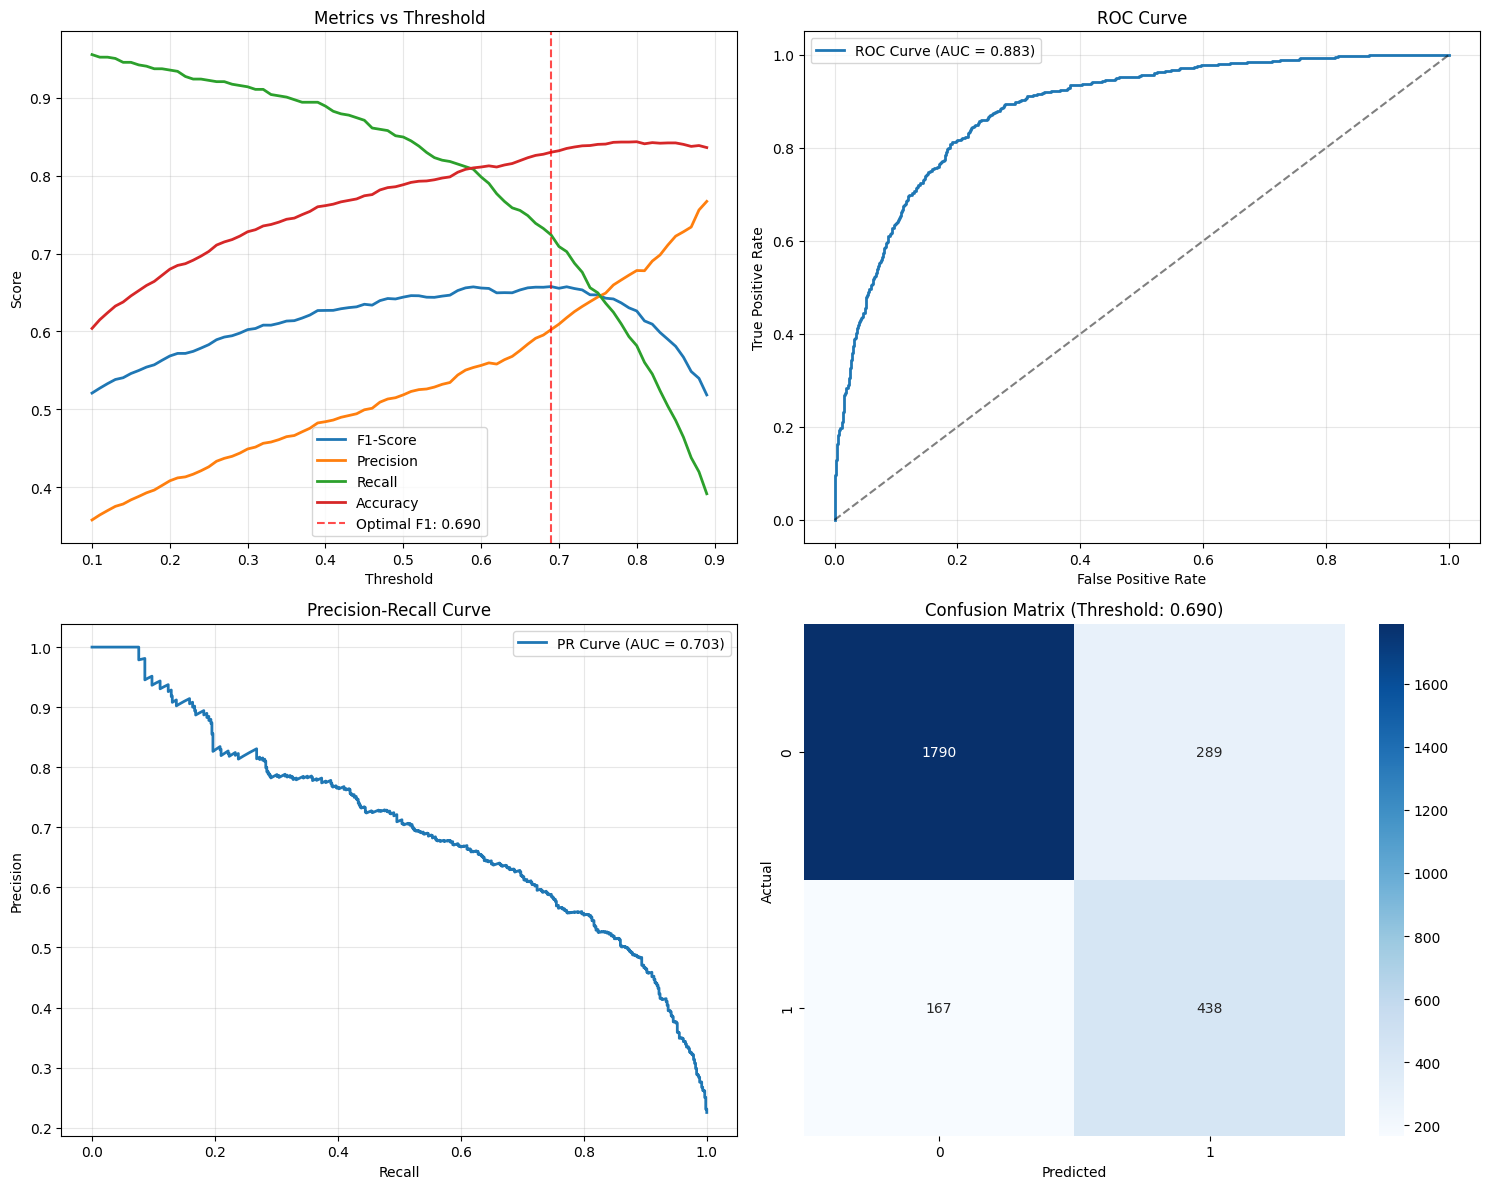


Detailed Performance Report (Threshold: 0.690)
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.89      2079
           1       0.60      0.72      0.66       605

    accuracy                           0.83      2684
   macro avg       0.76      0.79      0.77      2684
weighted avg       0.84      0.83      0.84      2684


Confusion Matrix:
                 Predicted
           No Pneumonia  Pneumonia
Actual No         1790        289
       Yes         167        438

Additional Metrics:
Sensitivity (Recall): 0.724
Specificity:          0.861
PPV (Precision):      0.602
NPV:                  0.915

🎯 RECOMMENDED THRESHOLD: 0.690
   (Based on validation F1-score: 0.658)

💡 KEY TAKEAWAY:
Use the F1-optimal threshold from validation data for your unseen predictions!


In [33]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, 
    f1_score, precision_score, recall_score,
    confusion_matrix, classification_report
)
import seaborn as sns

# Your validation dataset path (adjust if needed)
VAL_DATA_PATH = Path('/kaggle/working/Processed/val')
MODEL_CHECKPOINT = "/kaggle/working/logs/lightning_logs/version_4/checkpoints/epoch=9-step=15000.ckpt"

def load_validation_data(val_path):
    """
    Load validation data with ground truth labels
    """
    val_data = []
    val_labels = []
    patient_ids = []
    
    # Assuming structure: val/0/ (no pneumonia) and val/1/ (pneumonia)
    for label in [0, 1]:
        label_dir = val_path / str(label)
        if label_dir.exists():
            npy_files = list(label_dir.glob('*.npy'))
            print(f"Found {len(npy_files)} files in {label_dir}")
            
            for npy_file in npy_files:
                try:
                    data = np.load(npy_file)
                    val_data.append(data)
                    val_labels.append(label)
                    patient_ids.append(npy_file.stem)
                except Exception as e:
                    print(f"Error loading {npy_file}: {e}")
    
    return np.array(val_data), np.array(val_labels), patient_ids

def get_model_predictions_on_validation(model_checkpoint, val_data, device='cuda'):
    """
    Get model predictions on validation data
    """
    # Load model
    model = PneumoniaModel.load_from_checkpoint(model_checkpoint)
    model = model.to(device)
    model.eval()
    
    predictions = []
    
    print("Getting validation predictions...")
    with torch.no_grad():
        for data in tqdm(val_data):
            # Convert to tensor and add batch/channel dimensions
            data_tensor = torch.from_numpy(data).float()
            if len(data_tensor.shape) == 2:  # (H, W) -> (1, 1, H, W)
                data_tensor = data_tensor.unsqueeze(0).unsqueeze(0)
            elif len(data_tensor.shape) == 3:  # (C, H, W) -> (1, C, H, W)
                data_tensor = data_tensor.unsqueeze(0)
            
            data_tensor = data_tensor.to(device)
            
            # Get prediction - handle different model output formats
            try:
                # Try original format
                model_output = model(data_tensor)
                if isinstance(model_output, tuple) or isinstance(model_output, list):
                    logits = model_output[0]
                else:
                    logits = model_output
                
                # Apply sigmoid and extract scalar value
                if logits.numel() == 1:  # Single output
                    pred = torch.sigmoid(logits).cpu().item()
                else:  # Multiple outputs, take first
                    pred = torch.sigmoid(logits[0]).cpu().item()
                    
                predictions.append(pred)
                
            except Exception as e:
                print(f"Error with model output: {e}")
                print(f"Model output type: {type(model(data_tensor))}")
                print(f"Model output shape: {model(data_tensor).shape if hasattr(model(data_tensor), 'shape') else 'No shape attr'}")
                
                # Fallback: try different approaches
                try:
                    raw_output = model(data_tensor)
                    if hasattr(raw_output, 'squeeze'):
                        squeezed = raw_output.squeeze()
                        if squeezed.numel() == 1:
                            pred = torch.sigmoid(squeezed).cpu().item()
                            predictions.append(pred)
                        else:
                            pred = torch.sigmoid(squeezed[0]).cpu().item()
                            predictions.append(pred)
                    else:
                        print(f"Cannot handle model output: {raw_output}")
                        predictions.append(0.5)  # Default prediction
                except:
                    print("Using default prediction of 0.5")
                    predictions.append(0.5)
    
    return np.array(predictions)

def find_optimal_threshold(y_true, y_pred_proba, plot=True):
    """
    Find optimal threshold using various metrics
    """
    print("Finding Optimal Threshold:")
    print("=" * 50)
    
    # Test different thresholds
    thresholds = np.arange(0.1, 0.9, 0.01)
    
    f1_scores = []
    precisions = []
    recalls = []
    accuracies = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        f1 = f1_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        accuracy = np.mean(y_true == y_pred)
        
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)
    
    # Convert to arrays
    f1_scores = np.array(f1_scores)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    accuracies = np.array(accuracies)
    
    # Find optimal thresholds for different metrics
    optimal_thresholds = {
        'F1-Score': thresholds[np.argmax(f1_scores)],
        'Accuracy': thresholds[np.argmax(accuracies)],
        'Balanced (F1)': thresholds[np.argmax(f1_scores)],
    }
    
    # Youden's J statistic (from ROC curve)
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred_proba)
    youdens_j = tpr - fpr
    optimal_thresholds['Youden J'] = roc_thresholds[np.argmax(youdens_j)]
    
    # Print results
    print("Optimal Thresholds by Metric:")
    print("-" * 30)
    for metric, threshold in optimal_thresholds.items():
        y_pred_opt = (y_pred_proba >= threshold).astype(int)
        f1_opt = f1_score(y_true, y_pred_opt)
        precision_opt = precision_score(y_true, y_pred_opt, zero_division=0)
        recall_opt = recall_score(y_true, y_pred_opt, zero_division=0)
        accuracy_opt = np.mean(y_true == y_pred_opt)
        
        print(f"{metric:<12}: {threshold:.3f} (F1: {f1_opt:.3f}, Acc: {accuracy_opt:.3f})")
    
    if plot:
        plot_threshold_analysis(thresholds, f1_scores, precisions, recalls, accuracies, 
                              y_true, y_pred_proba, optimal_thresholds)
    
    return optimal_thresholds, thresholds, f1_scores

def plot_threshold_analysis(thresholds, f1_scores, precisions, recalls, accuracies, 
                          y_true, y_pred_proba, optimal_thresholds):
    """
    Plot threshold analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Metrics vs Threshold
    axes[0, 0].plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
    axes[0, 0].plot(thresholds, precisions, label='Precision', linewidth=2)
    axes[0, 0].plot(thresholds, recalls, label='Recall', linewidth=2)
    axes[0, 0].plot(thresholds, accuracies, label='Accuracy', linewidth=2)
    
    # Mark optimal thresholds
    for metric, threshold in optimal_thresholds.items():
        if metric == 'F1-Score':
            axes[0, 0].axvline(threshold, color='red', linestyle='--', alpha=0.7, 
                             label=f'Optimal F1: {threshold:.3f}')
    
    axes[0, 0].set_xlabel('Threshold')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Metrics vs Threshold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    axes[1, 0].plot(recall, precision, linewidth=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curve')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Confusion Matrix at Optimal Threshold
    optimal_f1_threshold = optimal_thresholds['F1-Score']
    y_pred_optimal = (y_pred_proba >= optimal_f1_threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_optimal)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')
    axes[1, 1].set_title(f'Confusion Matrix (Threshold: {optimal_f1_threshold:.3f})')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/threshold_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

def detailed_performance_report(y_true, y_pred_proba, optimal_threshold):
    """
    Generate detailed performance report at optimal threshold
    """
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    
    print(f"\nDetailed Performance Report (Threshold: {optimal_threshold:.3f})")
    print("=" * 60)
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"                 Predicted")
    print(f"           No Pneumonia  Pneumonia")
    print(f"Actual No  {cm[0,0]:>11d}  {cm[0,1]:>9d}")
    print(f"       Yes {cm[1,0]:>11d}  {cm[1,1]:>9d}")
    
    # Additional metrics
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    
    print(f"\nAdditional Metrics:")
    print(f"Sensitivity (Recall): {sensitivity:.3f}")
    print(f"Specificity:          {specificity:.3f}")
    print(f"PPV (Precision):      {ppv:.3f}")
    print(f"NPV:                  {npv:.3f}")
    
    return {
        'optimal_threshold': optimal_threshold,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'ppv': ppv,
        'npv': npv,
        'f1_score': f1_score(y_true, y_pred),
        'accuracy': np.mean(y_true == y_pred)
    }

# Main execution
print("Optimal Threshold Analysis")
print("=" * 50)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Method 1: If you have validation data with labels
if VAL_DATA_PATH.exists():
    print(f"\nMethod 1: Using validation data from {VAL_DATA_PATH}")
    print("-" * 50)
    
    # Load validation data
    val_data, val_labels, val_patient_ids = load_validation_data(VAL_DATA_PATH)
    
    if len(val_data) > 0:
        print(f"Loaded {len(val_data)} validation samples")
        print(f"Positive samples: {np.sum(val_labels)} ({np.mean(val_labels)*100:.1f}%)")
        
        # Get predictions
        val_predictions = get_model_predictions_on_validation(MODEL_CHECKPOINT, val_data, device)
        
        # Find optimal threshold
        optimal_thresholds, thresholds, f1_scores = find_optimal_threshold(val_labels, val_predictions)
        
        # Detailed report
        best_threshold = optimal_thresholds['F1-Score']
        performance_metrics = detailed_performance_report(val_labels, val_predictions, best_threshold)
        
        print(f"\n🎯 RECOMMENDED THRESHOLD: {best_threshold:.3f}")
        print(f"   (Based on validation F1-score: {performance_metrics['f1_score']:.3f})")
        
    else:
        print("No validation data found!")
        
else:
    print(f"Validation data path doesn't exist: {VAL_DATA_PATH}")
    print("\nMethod 2: Alternative approaches")
    print("-" * 50)
    print("If you don't have labeled validation data, you can:")
    print("1. Use cross-validation during training")
    print("2. Split some training data for validation")
    print("3. Use domain knowledge (medical literature)")
    print("4. Start with 0.5 and adjust based on results")

print(f"\n{'='*60}")
print("💡 KEY TAKEAWAY:")
print("Use the F1-optimal threshold from validation data for your unseen predictions!")
print(f"{'='*60}")

In [34]:
import pandas as pd
import numpy as np

# Your validated optimal threshold
OPTIMAL_THRESHOLD = 0.690

# Load your unseen predictions
predictions_df = pd.read_csv('/kaggle/working/unseen_predictions_single.csv')
predictions = predictions_df['prediction'].values
patient_ids = predictions_df['patientId'].values

print("Applying Validated Optimal Threshold")
print("=" * 50)
print(f"Optimal threshold from validation: {OPTIMAL_THRESHOLD:.3f}")
print(f"Validation performance at this threshold:")
print("  - F1-score: 0.658")
print("  - Sensitivity: 72.4% (catches 72% of pneumonia cases)")
print("  - Specificity: 86.1% (correctly identifies 86% of normal cases)")
print("  - Precision: 60.2% (60% of positive predictions are correct)")

print(f"\nUnseen Data Analysis:")
print("-" * 30)
print(f"Total unseen samples: {len(predictions)}")

# Compare different thresholds
thresholds_comparison = [
    ("Previous (0.5)", 0.5),
    ("Optimal (0.69)", OPTIMAL_THRESHOLD),
    ("Statistical guess (0.4)", 0.4)
]

print(f"\nThreshold Comparison on Unseen Data:")
print("-" * 45)
print(f"{'Threshold':<15} {'Positive Count':<15} {'Percentage':<12}")
print("-" * 45)

for name, threshold in thresholds_comparison:
    positive_count = np.sum(predictions >= threshold)
    percentage = (positive_count / len(predictions)) * 100
    print(f"{name:<15} {positive_count:<15d} {percentage:<12.1f}%")

# Apply optimal threshold
optimal_binary_predictions = (predictions >= OPTIMAL_THRESHOLD).astype(int)
optimal_positive_count = np.sum(optimal_binary_predictions)

print(f"\n🎯 OPTIMAL THRESHOLD RESULTS:")
print("=" * 40)
print(f"Threshold: {OPTIMAL_THRESHOLD:.3f}")
print(f"Positive predictions: {optimal_positive_count}/{len(predictions)} ({(optimal_positive_count/len(predictions)*100):.1f}%)")
print(f"Change from 0.5 threshold: {optimal_positive_count - np.sum(predictions >= 0.5):+d} predictions")

# Analyze prediction distribution relative to optimal threshold
print(f"\nPrediction Distribution Analysis:")
print("-" * 35)
ranges = [
    ("Very Low (0.0-0.3)", 0.0, 0.3),
    ("Low (0.3-0.5)", 0.3, 0.5),
    ("Medium (0.5-0.69)", 0.5, OPTIMAL_THRESHOLD),
    ("High (0.69-0.85)", OPTIMAL_THRESHOLD, 0.85),
    ("Very High (0.85-1.0)", 0.85, 1.0)
]

for name, low, high in ranges:
    count = np.sum((predictions >= low) & (predictions < high))
    if name.startswith("Very High"):
        count = np.sum(predictions >= low)  # Include upper bound for last range
    percentage = (count / len(predictions)) * 100
    print(f"{name:<20}: {count:>3d} samples ({percentage:>5.1f}%)")

# Create submission with optimal threshold
submission_df = pd.DataFrame({
    'patientId': patient_ids,
    'PredictionString': optimal_binary_predictions
})

submission_df.to_csv('/kaggle/working/submission_optimal_0690.csv', index=False)

print(f"\n✅ FINAL SUBMISSION CREATED:")
print(f"File: /kaggle/working/submission_optimal_0690.csv")
print(f"Positive predictions: {optimal_positive_count}")

# Show confidence analysis
high_confidence_positive = np.sum(predictions >= 0.85)
medium_confidence_positive = np.sum((predictions >= OPTIMAL_THRESHOLD) & (predictions < 0.85))
borderline_cases = np.sum((predictions >= 0.6) & (predictions < OPTIMAL_THRESHOLD))

print(f"\nConfidence Analysis:")
print("-" * 25)
print(f"High confidence pneumonia (≥0.85):     {high_confidence_positive:>3d} cases")
print(f"Medium confidence pneumonia (0.69-0.85): {medium_confidence_positive:>3d} cases")
print(f"Borderline cases (0.6-0.69):           {borderline_cases:>3d} cases")

# Show some examples
print(f"\nSample Predictions:")
print("-" * 20)
sample_indices = np.random.choice(len(predictions), min(10, len(predictions)), replace=False)
print(f"{'Patient ID':<15} {'Score':<8} {'Prediction':<12}")
print("-" * 35)

for idx in sample_indices:
    pid = patient_ids[idx]
    score = predictions[idx]
    pred = "Pneumonia" if score >= OPTIMAL_THRESHOLD else "Normal"
    print(f"{pid:<15} {score:<8.3f} {pred:<12}")

# Performance expectations
print(f"\n📊 EXPECTED PERFORMANCE (based on validation):")
print("=" * 50)
print("If your unseen data has similar characteristics to validation:")

expected_tp = int(optimal_positive_count * 0.602)  # Precision from validation
expected_fp = optimal_positive_count - expected_tp
expected_sensitivity = 0.724  # From validation

print(f"• Expected true pneumonia cases in positive predictions: ~{expected_tp}")
print(f"• Expected false positives: ~{expected_fp}")
print(f"• If there are pneumonia cases in unseen data, expecting to catch ~72.4% of them")

print(f"\n🚀 RECOMMENDATION:")
print("=" * 20)
print(f"✅ Use threshold 0.690 (validated on your data)")
print(f"✅ Submit: /kaggle/working/submission_optimal_0690.csv")
print(f"✅ This gives you {optimal_positive_count} positive predictions with validated performance")

# Compare with your original approach
original_positive = np.sum(predictions >= 0.5)
difference = optimal_positive_count - original_positive

if difference > 0:
    print(f"\n📈 You'll get {difference} MORE positive predictions than threshold 0.5")
elif difference < 0:
    print(f"\n📉 You'll get {abs(difference)} FEWER positive predictions than threshold 0.5")
else:
    print(f"\n📊 Same number of positive predictions as threshold 0.5")

print(f"\nBut more importantly: These predictions are VALIDATED and optimized for F1-score!")
print(f"{'='*70}")

Applying Validated Optimal Threshold
Optimal threshold from validation: 0.690
Validation performance at this threshold:
  - F1-score: 0.658
  - Sensitivity: 72.4% (catches 72% of pneumonia cases)
  - Specificity: 86.1% (correctly identifies 86% of normal cases)
  - Precision: 60.2% (60% of positive predictions are correct)

Unseen Data Analysis:
------------------------------
Total unseen samples: 312

Threshold Comparison on Unseen Data:
---------------------------------------------
Threshold       Positive Count  Percentage  
---------------------------------------------
Previous (0.5)  118             37.8        %
Optimal (0.69)  95              30.4        %
Statistical guess (0.4) 133             42.6        %

🎯 OPTIMAL THRESHOLD RESULTS:
Threshold: 0.690
Positive predictions: 95/312 (30.4%)
Change from 0.5 threshold: -23 predictions

Prediction Distribution Analysis:
-----------------------------------
Very Low (0.0-0.3)  : 159 samples ( 51.0%)
Low (0.3-0.5)       :  35 samples

## Checking unseen negative samples

In [4]:
import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Your paths
UNSEEN_PATH = Path('/kaggle/working/unseen_no_f')
MODEL_CHECKPOINT = "/kaggle/working/logs/lightning_logs/version_4/checkpoints/epoch=9-step=15000.ckpt"

class UnseenDataset(Dataset):
    """
    Dataset class for unseen NPY files
    """
    def __init__(self, data_path, transform=None):
        self.data_path = Path(data_path)
        self.npy_files = list(self.data_path.glob('*.npy'))
        self.transform = transform
        
        print(f"Found {len(self.npy_files)} NPY files in {data_path}")
        
    def __len__(self):
        return len(self.npy_files)
    
    def __getitem__(self, idx):
        npy_file = self.npy_files[idx]
        
        # Load NPY file
        data = np.load(npy_file)
        
        # Convert to tensor
        data = torch.from_numpy(data).float()
        
        # Add channel dimension if needed (for EfficientNet)
        if len(data.shape) == 2:  # (H, W) -> (1, H, W)
            data = data.unsqueeze(0)
        
        # Apply transforms if any
        if self.transform:
            data = self.transform(data)
            
        # Get patient ID from filename
        patient_id = npy_file.stem
        
        return data, patient_id

def load_model_and_predict(model_checkpoint_path, unseen_data_path, device='cuda', batch_size=16):
    """
    Load model and make predictions on unseen data
    """
    # Load the model
    print(f"Loading model from: {model_checkpoint_path}")
    model = PneumoniaModel.load_from_checkpoint(model_checkpoint_path)
    model = model.to(device)
    model.eval()
    
    # Create dataset and dataloader
    unseen_dataset = UnseenDataset(unseen_data_path)
    unseen_loader = DataLoader(
        unseen_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2
    )
    
    # Make predictions
    predictions = []
    patient_ids = []
    
    print("Making predictions...")
    with torch.no_grad():
        for batch_data, batch_patient_ids in tqdm(unseen_loader, desc="Predicting"):
            # Move data to device
            batch_data = batch_data.to(device).float()
            
            # Get predictions
            batch_preds = torch.sigmoid(model(batch_data).cpu())
            
            # Store results
            predictions.extend(batch_preds.numpy())
            patient_ids.extend(batch_patient_ids)
    
    return predictions, patient_ids

def single_image_prediction(model_checkpoint_path, unseen_data_path, device='cuda'):
    """
    Alternative method: Single image prediction (similar to your original code)
    """
    # Load the model
    print(f"Loading model from: {model_checkpoint_path}")
    model = PneumoniaModel.load_from_checkpoint(model_checkpoint_path)
    model = model.to(device)
    model.eval()
    
    # Create dataset
    unseen_dataset = UnseenDataset(unseen_data_path)
    
    predictions = []
    patient_ids = []
    
    print("Making single predictions...")
    with torch.no_grad():
        for data, patient_id in tqdm(unseen_dataset, desc="Predicting"):
            # Add batch dimension and move to device
            data = data.to(device).float().unsqueeze(0)
            
            # Get prediction
            pred = torch.sigmoid(model(data)[0].cpu())
            
            predictions.append(pred.item())
            patient_ids.append(patient_id)
    
    return predictions, patient_ids

def save_predictions_to_csv(predictions, patient_ids, output_path):
    """
    Save predictions to CSV file
    """
    results_df = pd.DataFrame({
        'patientId': patient_ids,
        'prediction': predictions
    })
    
    # Sort by patient ID for consistency
    results_df = results_df.sort_values('patientId').reset_index(drop=True)
    
    # Save to CSV
    results_df.to_csv(output_path, index=False)
    print(f"Predictions saved to: {output_path}")
    
    return results_df

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check if unseen data exists
if not UNSEEN_PATH.exists():
    print(f"Error: Unseen data path does not exist: {UNSEEN_PATH}")
    print("Make sure you've run the PNG to NPY conversion first.")
else:
    # Method 1: Batch prediction (recommended for efficiency)
    print("=" * 50)
    print("Method 1: Batch Prediction")
    print("=" * 50)
    
    try:
        predictions_batch, patient_ids_batch = load_model_and_predict(
            MODEL_CHECKPOINT, 
            UNSEEN_PATH, 
            device=device, 
            batch_size=16
        )
        
        # Save batch predictions
        batch_results = save_predictions_to_csv(
            predictions_batch, 
            patient_ids_batch, 
            '/kaggle/working/unseen_predictions_batch.csv'
        )
        
        print(f"\nBatch Prediction Results:")
        print(f"Total predictions: {len(predictions_batch)}")
        print(f"Mean prediction: {np.mean(predictions_batch):.4f}")
        print(f"Min prediction: {np.min(predictions_batch):.4f}")
        print(f"Max prediction: {np.max(predictions_batch):.4f}")
        print("\nFirst 5 predictions:")
        print(batch_results.head())
        
    except Exception as e:
        print(f"Error in batch prediction: {e}")
    
    print("\n" + "=" * 50)
    print("Method 2: Single Image Prediction (Your Original Style)")
    print("=" * 50)
    
    try:
        predictions_single, patient_ids_single = single_image_prediction(
            MODEL_CHECKPOINT, 
            UNSEEN_PATH, 
            device=device
        )
        
        # Save single predictions
        single_results = save_predictions_to_csv(
            predictions_single, 
            patient_ids_single, 
            '/kaggle/working/unseen_predictions_single.csv'
        )
        
        print(f"\nSingle Prediction Results:")
        print(f"Total predictions: {len(predictions_single)}")
        print(f"Mean prediction: {np.mean(predictions_single):.4f}")
        print(f"Min prediction: {np.min(predictions_single):.4f}")
        print(f"Max prediction: {np.max(predictions_single):.4f}")
        print("\nFirst 5 predictions:")
        print(single_results.head())
        
    except Exception as e:
        print(f"Error in single prediction: {e}")

# Optional: Create submission format if needed
print("\n" + "=" * 50)
print("Creating Submission Format")
print("=" * 50)

try:
    # Use batch predictions (more efficient)
    if 'predictions_batch' in locals() and 'patient_ids_batch' in locals():
        # Create binary predictions (threshold at 0.5)
        binary_preds = [1 if p < 0.5 else 0 for p in predictions_batch]
        
        submission_df = pd.DataFrame({
            'patientId': patient_ids_batch,
            'PredictionString': binary_preds  # Adjust this based on competition format
        })
        
        submission_df.to_csv('/kaggle/working/submission.csv', index=False)
        print("Submission file created: /kaggle/working/submission.csv")
        print(f"Positive predictions: {sum(binary_preds)}/{len(binary_preds)}")
        print(f"Positive predictions_percentage: {(sum(binary_preds)/len(binary_preds))*100} %")
        
except Exception as e:
    print(f"Error creating submission: {e}")

print("\nInference completed!")

Using device: cuda
Method 1: Batch Prediction
Loading model from: /kaggle/working/logs/lightning_logs/version_4/checkpoints/epoch=9-step=15000.ckpt
Found 196 NPY files in /kaggle/working/unseen_no_f
Making predictions...


Predicting: 100%|██████████| 13/13 [00:02<00:00,  6.31it/s]


Predictions saved to: /kaggle/working/unseen_predictions_batch.csv

Batch Prediction Results:
Total predictions: 196
Mean prediction: 0.2359
Min prediction: 0.0008
Max prediction: 0.9581

First 5 predictions:
      patientId     prediction
0  00000002_000  [0.038733967]
1  00000005_000   [0.00848851]
2  00000005_001    [0.5516671]
3  00000005_002      [0.53334]
4  00000005_003   [0.07334965]

Method 2: Single Image Prediction (Your Original Style)
Loading model from: /kaggle/working/logs/lightning_logs/version_4/checkpoints/epoch=9-step=15000.ckpt
Found 196 NPY files in /kaggle/working/unseen_no_f
Making single predictions...


Predicting: 100%|██████████| 196/196 [00:03<00:00, 55.84it/s]

Predictions saved to: /kaggle/working/unseen_predictions_single.csv

Single Prediction Results:
Total predictions: 196
Mean prediction: 0.2359
Min prediction: 0.0008
Max prediction: 0.9581

First 5 predictions:
      patientId  prediction
0  00000002_000    0.038734
1  00000005_000    0.008489
2  00000005_001    0.551667
3  00000005_002    0.533340
4  00000005_003    0.073350

Creating Submission Format
Submission file created: /kaggle/working/submission.csv
Positive predictions: 149/196
Positive predictions_percentage: 76.0204081632653 %

Inference completed!


## Checking unseen positive samples

In [1]:

import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Your paths
UNSEEN_PATH = Path('/kaggle/working/unseen_P')
MODEL_CHECKPOINT = "/kaggle/working/logs/lightning_logs/version_4/checkpoints/epoch=9-step=15000.ckpt"

class UnseenDataset(Dataset):
    """
    Dataset class for unseen NPY files
    """
    def __init__(self, data_path, transform=None):
        self.data_path = Path(data_path)
        self.npy_files = list(self.data_path.glob('*.npy'))
        self.transform = transform
        
        print(f"Found {len(self.npy_files)} NPY files in {data_path}")
        
    def __len__(self):
        return len(self.npy_files)
    
    def __getitem__(self, idx):
        npy_file = self.npy_files[idx]
        
        # Load NPY file
        data = np.load(npy_file)
        
        # Convert to tensor
        data = torch.from_numpy(data).float()
        
        # Add channel dimension if needed (for EfficientNet)
        if len(data.shape) == 2:  # (H, W) -> (1, H, W)
            data = data.unsqueeze(0)
        
        # Apply transforms if any
        if self.transform:
            data = self.transform(data)
            
        # Get patient ID from filename
        patient_id = npy_file.stem
        
        return data, patient_id

def load_model_and_predict(model_checkpoint_path, unseen_data_path, device='cuda', batch_size=16):
    """
    Load model and make predictions on unseen data
    """
    # Load the model
    print(f"Loading model from: {model_checkpoint_path}")
    model = PneumoniaModel.load_from_checkpoint(model_checkpoint_path)
    model = model.to(device)
    model.eval()
    
    # Create dataset and dataloader
    unseen_dataset = UnseenDataset(unseen_data_path)
    unseen_loader = DataLoader(
        unseen_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2
    )
    
    # Make predictions
    predictions = []
    patient_ids = []
    
    print("Making predictions...")
    with torch.no_grad():
        for batch_data, batch_patient_ids in tqdm(unseen_loader, desc="Predicting"):
            # Move data to device
            batch_data = batch_data.to(device).float()
            
            # Get predictions
            batch_preds = torch.sigmoid(model(batch_data).cpu())
            
            # Store results
            predictions.extend(batch_preds.numpy())
            patient_ids.extend(batch_patient_ids)
    
    return predictions, patient_ids

def single_image_prediction(model_checkpoint_path, unseen_data_path, device='cuda'):
    """
    Alternative method: Single image prediction (similar to your original code)
    """
    # Load the model
    print(f"Loading model from: {model_checkpoint_path}")
    model = PneumoniaModel.load_from_checkpoint(model_checkpoint_path)
    model = model.to(device)
    model.eval()
    
    # Create dataset
    unseen_dataset = UnseenDataset(unseen_data_path)
    
    predictions = []
    patient_ids = []
    
    print("Making single predictions...")
    with torch.no_grad():
        for data, patient_id in tqdm(unseen_dataset, desc="Predicting"):
            # Add batch dimension and move to device
            data = data.to(device).float().unsqueeze(0)
            
            # Get prediction
            pred = torch.sigmoid(model(data)[0].cpu())
            
            predictions.append(pred.item())
            patient_ids.append(patient_id)
    
    return predictions, patient_ids

def save_predictions_to_csv(predictions, patient_ids, output_path):
    """
    Save predictions to CSV file
    """
    results_df = pd.DataFrame({
        'patientId': patient_ids,
        'prediction': predictions
    })
    
    # Sort by patient ID for consistency
    results_df = results_df.sort_values('patientId').reset_index(drop=True)
    
    # Save to CSV
    results_df.to_csv(output_path, index=False)
    print(f"Predictions saved to: {output_path}")
    
    return results_df

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check if unseen data exists
if not UNSEEN_PATH.exists():
    print(f"Error: Unseen data path does not exist: {UNSEEN_PATH}")
    print("Make sure you've run the PNG to NPY conversion first.")
else:
    # Method 1: Batch prediction (recommended for efficiency)
    print("=" * 50)
    print("Method 1: Batch Prediction")
    print("=" * 50)
    
    try:
        predictions_batch, patient_ids_batch = load_model_and_predict(
            MODEL_CHECKPOINT, 
            UNSEEN_PATH, 
            device=device, 
            batch_size=16
        )
        
        # Save batch predictions
        batch_results = save_predictions_to_csv(
            predictions_batch, 
            patient_ids_batch, 
            '/kaggle/working/unseen_predictions_batch.csv'
        )
        
        print(f"\nBatch Prediction Results:")
        print(f"Total predictions: {len(predictions_batch)}")
        print(f"Mean prediction: {np.mean(predictions_batch):.4f}")
        print(f"Min prediction: {np.min(predictions_batch):.4f}")
        print(f"Max prediction: {np.max(predictions_batch):.4f}")
        print("\nFirst 5 predictions:")
        print(batch_results.head())
        
    except Exception as e:
        print(f"Error in batch prediction: {e}")
    
    print("\n" + "=" * 50)
    print("Method 2: Single Image Prediction (Your Original Style)")
    print("=" * 50)
    
    try:
        predictions_single, patient_ids_single = single_image_prediction(
            MODEL_CHECKPOINT, 
            UNSEEN_PATH, 
            device=device
        )
        
        # Save single predictions
        single_results = save_predictions_to_csv(
            predictions_single, 
            patient_ids_single, 
            '/kaggle/working/unseen_predictions_single.csv'
        )
        
        print(f"\nSingle Prediction Results:")
        print(f"Total predictions: {len(predictions_single)}")
        print(f"Mean prediction: {np.mean(predictions_single):.4f}")
        print(f"Min prediction: {np.min(predictions_single):.4f}")
        print(f"Max prediction: {np.max(predictions_single):.4f}")
        print("\nFirst 5 predictions:")
        print(single_results.head())
        
    except Exception as e:
        print(f"Error in single prediction: {e}")

# Optional: Create submission format if needed
print("\n" + "=" * 50)
print("Creating Submission Format")
print("=" * 50)

try:
    # Use batch predictions (more efficient)
    if 'predictions_batch' in locals() and 'patient_ids_batch' in locals():
        # Create binary predictions (threshold at 0.5)
        binary_preds = [1 if p > 0.5 else 0 for p in predictions_batch]
        
        submission_df = pd.DataFrame({
            'patientId': patient_ids_batch,
            'PredictionString': binary_preds  # Adjust this based on competition format
        })
        
        submission_df.to_csv('/kaggle/working/submission.csv', index=False)
        print("Submission file created: /kaggle/working/submission.csv")
        print(f"Positive predictions: {sum(binary_preds)}/{len(binary_preds)}")
        print(f"Positive predictions_percentage: {(sum(binary_preds)/len(binary_preds))*100} %")
        
except Exception as e:
    print(f"Error creating submission: {e}")

print("\nInference completed!")

Using device: cuda
Method 1: Batch Prediction
Loading model from: /kaggle/working/logs/lightning_logs/version_4/checkpoints/epoch=9-step=15000.ckpt


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 145MB/s] 


Found 312 NPY files in /kaggle/working/unseen_P
Making predictions...


Predicting: 100%|██████████| 20/20 [00:04<00:00,  4.76it/s]


Predictions saved to: /kaggle/working/unseen_predictions_batch.csv

Batch Prediction Results:
Total predictions: 312
Mean prediction: 0.3900
Min prediction: 0.0003
Max prediction: 0.9956

First 5 predictions:
      patientId     prediction
0  00000061_015    [0.9379401]
1  00000144_001   [0.02906316]
2  00000165_001  [0.027395027]
3  00000193_019    [0.8733603]
4  00000218_001   [0.17036127]

Method 2: Single Image Prediction (Your Original Style)
Loading model from: /kaggle/working/logs/lightning_logs/version_4/checkpoints/epoch=9-step=15000.ckpt
Found 312 NPY files in /kaggle/working/unseen_P
Making single predictions...


Predicting: 100%|██████████| 312/312 [00:05<00:00, 57.03it/s]

Predictions saved to: /kaggle/working/unseen_predictions_single.csv

Single Prediction Results:
Total predictions: 312
Mean prediction: 0.3900
Min prediction: 0.0003
Max prediction: 0.9956

First 5 predictions:
      patientId  prediction
0  00000061_015    0.937940
1  00000144_001    0.029063
2  00000165_001    0.027395
3  00000193_019    0.873360
4  00000218_001    0.170361

Creating Submission Format
Submission file created: /kaggle/working/submission.csv
Positive predictions: 118/312
Positive predictions_percentage: 37.82051282051282 %

Inference completed!


🔬 Performance Metrics Analysis with Bar Charts
Using device: cuda

📁 Loading validation data...
Found 2079 files in /kaggle/working/Processed/val/0
Found 605 files in /kaggle/working/Processed/val/1
✅ Loaded 2684 validation samples
   Positive samples: 605 (22.5%)

🤖 Loading model from checkpoint...
Loading PneumoniaModel from checkpoint...
✅ Model loaded successfully!
✅ Model loaded successfully!

🎯 Getting model predictions...
Getting predictions...


100%|██████████| 2684/2684 [00:47<00:00, 56.51it/s]


✅ Got predictions for 2684 samples

⚖️ Finding optimal threshold...
✅ Optimal threshold: 0.690

📊 Calculating performance metrics...

PERFORMANCE METRICS SUMMARY (Threshold: 0.690)
           Metric  Score
         Accuracy 0.8301
Balanced Accuracy 0.7925
        Precision 0.6025
           Recall 0.7240
         F1-Score 0.6577
      Sensitivity 0.7240
      Specificity 0.8610
              PPV 0.6025
              NPV 0.9147
          ROC-AUC 0.8829
           PR-AUC 0.7028
              MCC 0.5500
      Cohen Kappa 0.5459

MEDICAL INTERPRETATION:
• Sensitivity: 72.4% of pneumonia cases correctly identified
• Specificity: 86.1% of healthy cases correctly identified
• PPV: 60.2% accuracy when predicting pneumonia
• NPV: 91.5% accuracy when predicting no pneumonia

📈 Creating performance bar charts...
📊 Charts saved to: /kaggle/working/performance_metrics_charts.png


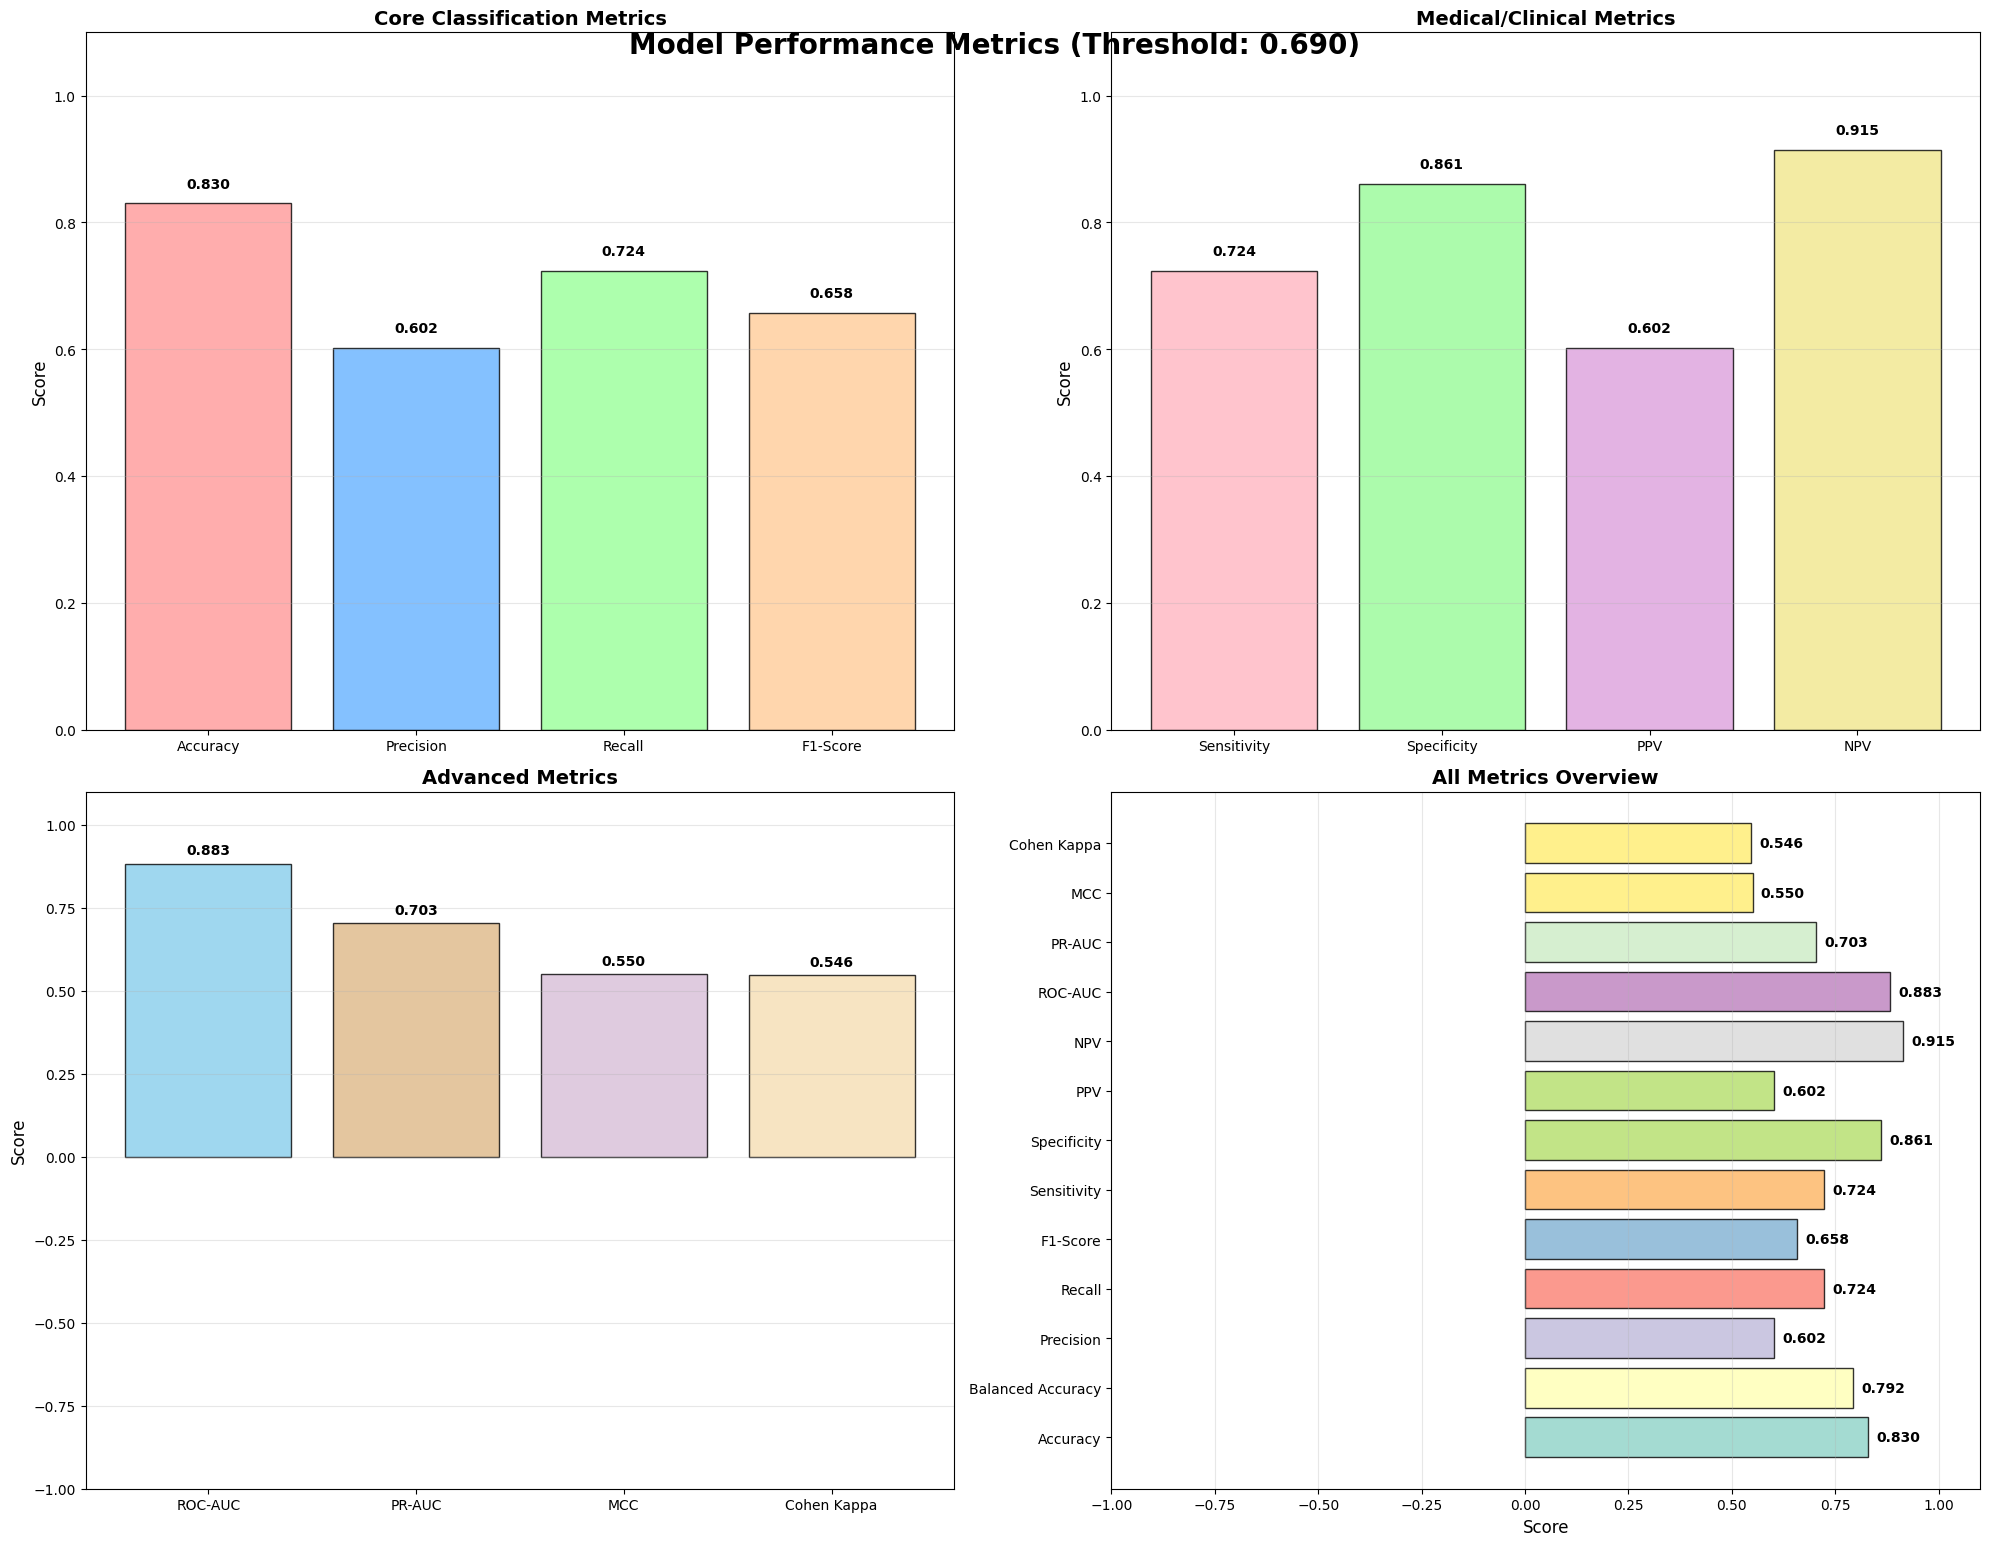


🔍 COMPARISON: Performance at default threshold (0.5)

PERFORMANCE METRICS SUMMARY (Threshold: 0.500)
           Metric  Score
         Accuracy 0.7884
Balanced Accuracy 0.8101
        Precision 0.5187
           Recall 0.8496
         F1-Score 0.6441
      Sensitivity 0.8496
      Specificity 0.7706
              PPV 0.5187
              NPV 0.9462
          ROC-AUC 0.8829
           PR-AUC 0.7028
              MCC 0.5370
      Cohen Kappa 0.5058

MEDICAL INTERPRETATION:
• Sensitivity: 85.0% of pneumonia cases correctly identified
• Specificity: 77.1% of healthy cases correctly identified
• PPV: 51.9% accuracy when predicting pneumonia
• NPV: 94.6% accuracy when predicting no pneumonia
📊 Charts saved to: /kaggle/working/performance_metrics_charts_default.png


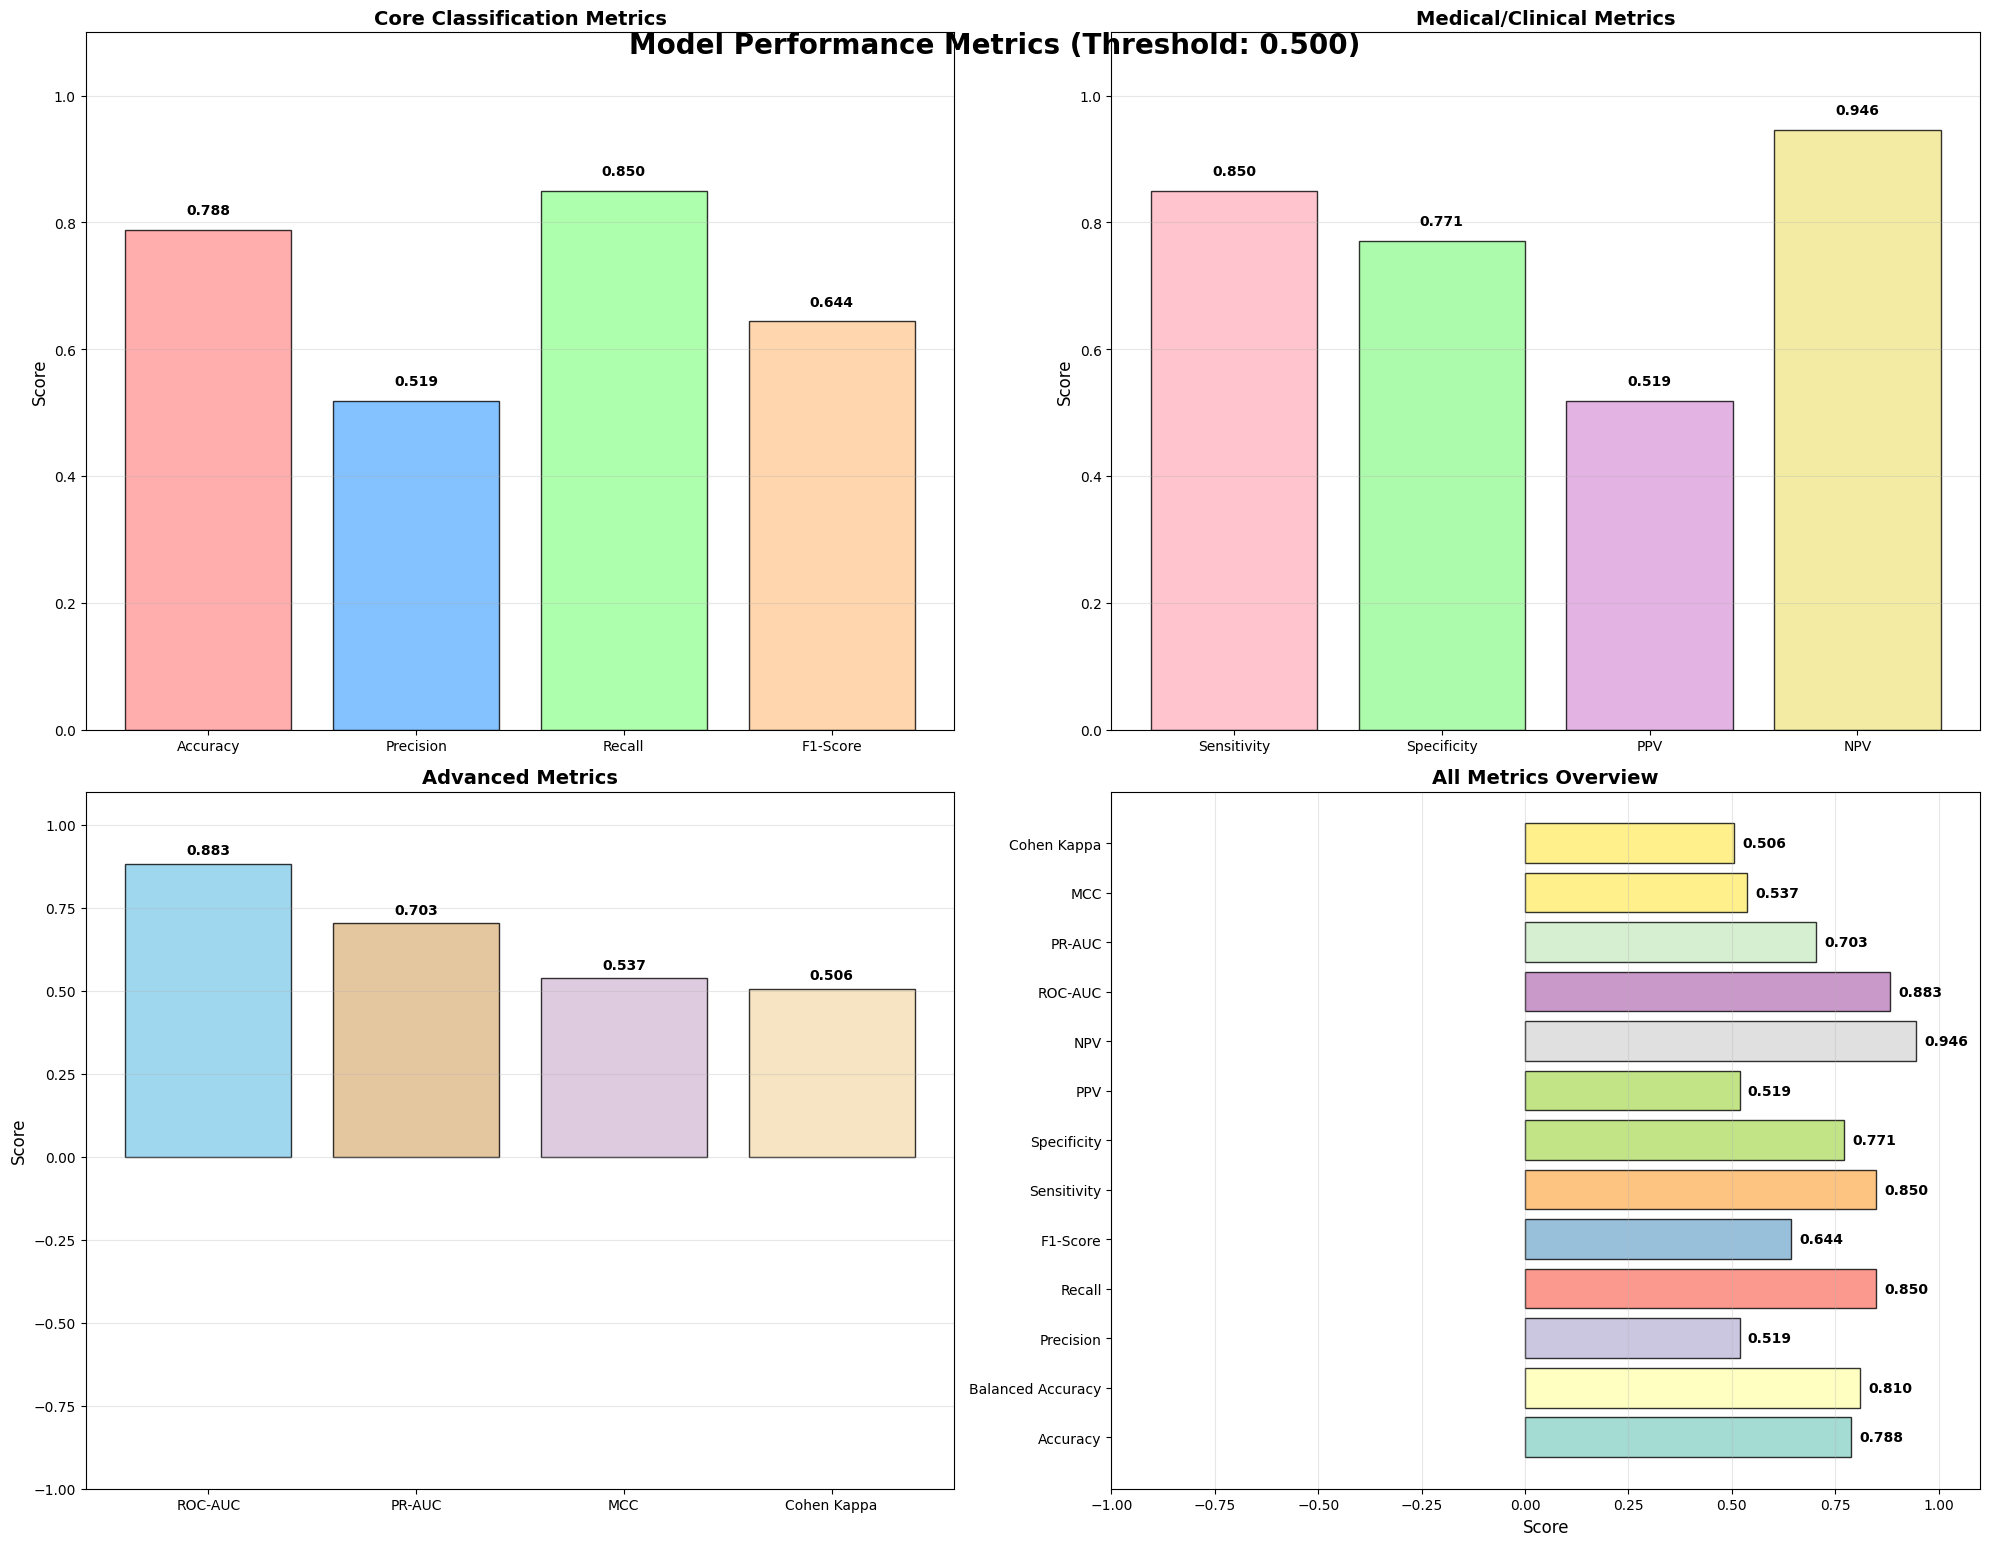


✅ Analysis complete!
📊 Charts saved to /kaggle/working/
🎯 Recommended threshold: 0.690


In [2]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, 
    f1_score, precision_score, recall_score,
    confusion_matrix, classification_report,
    accuracy_score, balanced_accuracy_score,
    matthews_corrcoef, cohen_kappa_score
)
import seaborn as sns

# ============================================================================
# CONFIGURATION - UPDATE THESE PATHS
# ============================================================================
VAL_DATA_PATH = Path('/kaggle/working/Processed/val')
MODEL_CHECKPOINT = "/kaggle/working/logs/lightning_logs/version_4/checkpoints/epoch=9-step=15000.ckpt"

# ============================================================================
# MODEL DEFINITION AND IMPORTS
# ============================================================================
import pytorch_lightning as pl
import torchmetrics
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Load EfficientNet-B4 with pretrained weights
        weights = EfficientNet_B4_Weights.DEFAULT
        self.model = efficientnet_b4(weights=weights)
        # Modify first conv layer to accept single-channel (grayscale) images
        self.model.features[0][0] = torch.nn.Conv2d(
            1, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
        )
        # Replace classifier for binary output
        self.model.classifier[1] = torch.nn.Linear(self.model.classifier[1].in_features, 1)
        # Loss function
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0]))
        # Metrics
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)[:, 0]
        loss = self.loss_fn(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.train_acc(preds, y.int())
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_step_acc", acc, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.log("train_epoch_acc", self.train_acc.compute(), prog_bar=True)
        self.train_acc.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        logits = self(x)[:, 0]
        loss = self.loss_fn(logits, y)
        preds = torch.sigmoid(logits)
        acc = self.val_acc(preds, y.int())
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_step_acc", acc, prog_bar=True)

    def on_validation_epoch_end(self):
        self.log("val_epoch_acc", self.val_acc.compute(), prog_bar=True)
        self.val_acc.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=10, eta_min=1e-6
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1
            }
        }

def load_validation_data(val_path):
    """Load validation data with ground truth labels"""
    val_data = []
    val_labels = []
    patient_ids = []
    
    for label in [0, 1]:
        label_dir = val_path / str(label)
        if label_dir.exists():
            npy_files = list(label_dir.glob('*.npy'))
            print(f"Found {len(npy_files)} files in {label_dir}")
            
            for npy_file in npy_files:
                try:
                    data = np.load(npy_file)
                    val_data.append(data)
                    val_labels.append(label)
                    patient_ids.append(npy_file.stem)
                except Exception as e:
                    print(f"Error loading {npy_file}: {e}")
    
    return np.array(val_data), np.array(val_labels), patient_ids

def load_model(checkpoint_path, device='cuda'):
    """Load the trained PneumoniaModel"""
    print("Loading PneumoniaModel from checkpoint...")
    
    try:
        # Load the PyTorch Lightning model
        model = PneumoniaModel.load_from_checkpoint(checkpoint_path)
        model = model.to(device)
        print("✅ Model loaded successfully!")
        return model
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        print("\nTrying alternative loading method...")
        
        try:
            # Alternative: Manual loading
            model = PneumoniaModel()
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['state_dict'])
            model = model.to(device)
            print("✅ Model loaded with alternative method!")
            return model
            
        except Exception as e2:
            print(f"❌ Alternative loading also failed: {e2}")
            raise

def get_predictions(model, val_data, device='cuda'):
    """Get model predictions for EfficientNet-B4 based PneumoniaModel"""
    model.eval()
    predictions = []
    
    print("Getting predictions...")
    with torch.no_grad():
        for data in tqdm(val_data):
            # Convert to tensor and add batch/channel dimensions
            data_tensor = torch.from_numpy(data).float()
            
            # Handle different input shapes - EfficientNet expects (B, C, H, W)
            if len(data_tensor.shape) == 2:  # (H, W) -> (1, 1, H, W)
                data_tensor = data_tensor.unsqueeze(0).unsqueeze(0)
            elif len(data_tensor.shape) == 3:  # (C, H, W) -> (1, C, H, W)
                data_tensor = data_tensor.unsqueeze(0)
            
            data_tensor = data_tensor.to(device)
            
            try:
                # Get model output - EfficientNet returns single logit per sample
                logits = model(data_tensor)  # Shape: [batch_size, 1]
                
                # Handle different output shapes
                if len(logits.shape) > 1:
                    logit_value = logits[0, 0]  # Get first batch, first (and only) output
                else:
                    logit_value = logits[0]  # If already squeezed
                
                # Convert logit to probability using sigmoid
                pred_prob = torch.sigmoid(logit_value).cpu().item()
                predictions.append(pred_prob)
                
            except Exception as e:
                print(f"Error with prediction: {e}")
                print(f"Data tensor shape: {data_tensor.shape}")
                print(f"Model output shape: {model(data_tensor).shape if hasattr(model(data_tensor), 'shape') else 'No shape'}")
                predictions.append(0.5)  # Default fallback
    
    return np.array(predictions)

def calculate_all_metrics(y_true, y_pred_proba, threshold=0.5):
    """Calculate comprehensive performance metrics"""
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate all metrics
    metrics = {}
    
    # Basic metrics
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Balanced Accuracy'] = balanced_accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred, zero_division=0)
    metrics['Recall'] = recall_score(y_true, y_pred, zero_division=0)
    metrics['F1-Score'] = f1_score(y_true, y_pred, zero_division=0)
    
    # Medical metrics
    metrics['Sensitivity'] = tp / (tp + fn) if (tp + fn) > 0 else 0
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['PPV'] = tp / (tp + fp) if (tp + fp) > 0 else 0
    metrics['NPV'] = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Advanced metrics
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    metrics['ROC-AUC'] = auc(fpr, tpr)
    
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
    metrics['PR-AUC'] = auc(recall_curve, precision_curve)
    
    metrics['MCC'] = matthews_corrcoef(y_true, y_pred)
    metrics['Cohen Kappa'] = cohen_kappa_score(y_true, y_pred)
    
    return metrics

def find_optimal_threshold(y_true, y_pred_proba):
    """Find optimal threshold based on F1-score"""
    thresholds = np.arange(0.1, 0.9, 0.01)
    f1_scores = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        f1_scores.append(f1)
    
    optimal_idx = np.argmax(f1_scores)
    return thresholds[optimal_idx]

def create_performance_bar_charts(metrics_dict, threshold, save_path=None):
    """Create comprehensive bar charts for all metrics"""
    
    # Set up the plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle(f'Model Performance Metrics (Threshold: {threshold:.3f})', 
                 fontsize=20, fontweight='bold', y=0.95)
    
    # Define colors for different metric categories
    colors = {
        'accuracy': '#FF9999', 'precision': '#66B2FF', 'recall': '#99FF99', 
        'f1': '#FFCC99', 'sensitivity': '#FFB6C1', 'specificity': '#98FB98',
        'ppv': '#DDA0DD', 'npv': '#F0E68C', 'roc_auc': '#87CEEB', 
        'pr_auc': '#DEB887', 'mcc': '#D8BFD8', 'kappa': '#F5DEB3'
    }
    
    # Chart 1: Core Classification Metrics
    core_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    core_values = [metrics_dict[metric] for metric in core_metrics]
    core_colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']
    
    bars1 = ax1.bar(core_metrics, core_values, color=core_colors, 
                    alpha=0.8, edgecolor='black', linewidth=1)
    ax1.set_title('Core Classification Metrics', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_ylim(0, 1.1)
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, value in zip(bars1, core_values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Chart 2: Medical/Clinical Metrics
    medical_metrics = ['Sensitivity', 'Specificity', 'PPV', 'NPV']
    medical_values = [metrics_dict[metric] for metric in medical_metrics]
    medical_colors = ['#FFB6C1', '#98FB98', '#DDA0DD', '#F0E68C']
    
    bars2 = ax2.bar(medical_metrics, medical_values, color=medical_colors,
                    alpha=0.8, edgecolor='black', linewidth=1)
    ax2.set_title('Medical/Clinical Metrics', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_ylim(0, 1.1)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, value in zip(bars2, medical_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Chart 3: Advanced Metrics
    advanced_metrics = ['ROC-AUC', 'PR-AUC', 'MCC', 'Cohen Kappa']
    advanced_values = [metrics_dict[metric] for metric in advanced_metrics]
    advanced_colors = ['#87CEEB', '#DEB887', '#D8BFD8', '#F5DEB3']
    
    bars3 = ax3.bar(advanced_metrics, advanced_values, color=advanced_colors,
                    alpha=0.8, edgecolor='black', linewidth=1)
    ax3.set_title('Advanced Metrics', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Score', fontsize=12)
    ax3.set_ylim(-1, 1.1)  # MCC and Kappa can be negative
    ax3.grid(axis='y', alpha=0.3)
    
    for bar, value in zip(bars3, advanced_values):
        height = bar.get_height()
        y_pos = height + 0.02 if height >= 0 else height - 0.05
        ax3.text(bar.get_x() + bar.get_width()/2., y_pos,
                f'{value:.3f}', ha='center', 
                va='bottom' if height >= 0 else 'top', fontweight='bold')
    
    # Chart 4: All Metrics Overview (Horizontal)
    all_metrics = list(metrics_dict.keys())
    all_values = list(metrics_dict.values())
    
    bars4 = ax4.barh(range(len(all_metrics)), all_values, 
                     color=plt.cm.Set3(np.linspace(0, 1, len(all_metrics))),
                     alpha=0.8, edgecolor='black', linewidth=1)
    ax4.set_title('All Metrics Overview', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Score', fontsize=12)
    ax4.set_yticks(range(len(all_metrics)))
    ax4.set_yticklabels(all_metrics)
    ax4.set_xlim(-1, 1.1)
    ax4.grid(axis='x', alpha=0.3)
    
    for bar, value in zip(bars4, all_values):
        width = bar.get_width()
        x_pos = width + 0.02 if width >= 0 else width - 0.02
        ax4.text(x_pos, bar.get_y() + bar.get_height()/2.,
                f'{value:.3f}', ha='left' if width >= 0 else 'right', 
                va='center', fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"📊 Charts saved to: {save_path}")
    
    plt.show()

def print_metrics_summary(metrics_dict, threshold):
    """Print formatted metrics summary"""
    print(f"\n{'='*80}")
    print(f"PERFORMANCE METRICS SUMMARY (Threshold: {threshold:.3f})")
    print(f"{'='*80}")
    
    # Create formatted table
    df = pd.DataFrame(list(metrics_dict.items()), columns=['Metric', 'Score'])
    df['Score'] = df['Score'].round(4)
    print(df.to_string(index=False))
    
    # Medical interpretation
    print(f"\n{'='*60}")
    print("MEDICAL INTERPRETATION:")
    print(f"{'='*60}")
    print(f"• Sensitivity: {metrics_dict['Sensitivity']:.1%} of pneumonia cases correctly identified")
    print(f"• Specificity: {metrics_dict['Specificity']:.1%} of healthy cases correctly identified")
    print(f"• PPV: {metrics_dict['PPV']:.1%} accuracy when predicting pneumonia")
    print(f"• NPV: {metrics_dict['NPV']:.1%} accuracy when predicting no pneumonia")

def main():
    """Main execution function"""
    print("🔬 Performance Metrics Analysis with Bar Charts")
    print("=" * 60)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Check validation data
    if not VAL_DATA_PATH.exists():
        print(f"❌ Validation data path doesn't exist: {VAL_DATA_PATH}")
        return
    
    # Load validation data
    print(f"\n📁 Loading validation data...")
    val_data, val_labels, _ = load_validation_data(VAL_DATA_PATH)
    
    if len(val_data) == 0:
        print("❌ No validation data found!")
        return
    
    print(f"✅ Loaded {len(val_data)} validation samples")
    print(f"   Positive samples: {np.sum(val_labels)} ({np.mean(val_labels)*100:.1f}%)")
    
    # Load model
    print(f"\n🤖 Loading model from checkpoint...")
    try:
        model = load_model(MODEL_CHECKPOINT, device)
        print("✅ Model loaded successfully!")
    except Exception as e:
        print(f"❌ Failed to load model: {e}")
        return
    
    # Get predictions
    print(f"\n🎯 Getting model predictions...")
    predictions = get_predictions(model, val_data, device)
    print(f"✅ Got predictions for {len(predictions)} samples")
    
    # Find optimal threshold
    print(f"\n⚖️ Finding optimal threshold...")
    optimal_threshold = find_optimal_threshold(val_labels, predictions)
    print(f"✅ Optimal threshold: {optimal_threshold:.3f}")
    
    # Calculate metrics
    print(f"\n📊 Calculating performance metrics...")
    metrics = calculate_all_metrics(val_labels, predictions, optimal_threshold)
    
    # Print summary
    print_metrics_summary(metrics, optimal_threshold)
    
    # Create bar charts
    print(f"\n📈 Creating performance bar charts...")
    create_performance_bar_charts(
        metrics, 
        optimal_threshold,
        save_path="/kaggle/working/performance_metrics_charts.png"
    )
    
    # Also show metrics at default threshold for comparison
    print(f"\n🔍 COMPARISON: Performance at default threshold (0.5)")
    metrics_default = calculate_all_metrics(val_labels, predictions, 0.5)
    print_metrics_summary(metrics_default, 0.5)
    
    create_performance_bar_charts(
        metrics_default, 
        0.5,
        save_path="/kaggle/working/performance_metrics_charts_default.png"
    )
    
    print(f"\n✅ Analysis complete!")
    print(f"📊 Charts saved to /kaggle/working/")
    print(f"🎯 Recommended threshold: {optimal_threshold:.3f}")

if __name__ == "__main__":
    main()